# Mobile DiscussionTools AB Test Analysis Report

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

** Last update: 8 February 2023**

[TASK](https://phabricator.wikimedia.org/T298062) | [CODEBASE]()

# Contents

1. [Introduction](#Introduction)
2. [Methodology](#Methodology)
3. [Total Edits](#Total-edits)
3. [Revert rate](#Revert-rate)
3. [Edit completion rate](#Edit-completion-rate)
4. [Proportion of editors who make at least 1 successful edit](#Proportion-of-unique-editors-that-sucessfully-save-at-least-1-edit)

# Introduction

The Wikimedia Foundation's [Editing team](https://www.mediawiki.org/wiki/Editing_team#:~:text=The%20Editing%20team%20is%20the,tools%20like%20TemplateData%20and%20Citoid.) is working to improve how contributors communicate on Wikipedia using talk pages through a series of incremental improvements that will be released over time.

As part of this effort, the Editing team is evaluating the impact of disabling the MobileFrontend talk page overlay and introducing a suite of DiscussionTools to mobile talk pages. The suite of tools includes the Reply tool, New Topic Tool, Topic Subscriptions and Usability Improvements. 

The team ran an AB test of DiscussionTools on Mobile from 3 January 2023 through 23 January 2023 to evaluate the suite of mobile DiscussionTools being introduced on talk pages. The test included all logged-in and logged-out users [1] that edited a talk page at one the 15 participating Wikipedias during the duration of the AB test (see full list of [participating Wikipedias in task description](https://phabricator.wikimedia.org/T320993) and conditions outlined in the methodology section below).

The results of the A/B test will help us make the following decision: Are the set of mobile Talk Pages Project features fit to be made available to everyone, at all wikis, by default?

You can find more information about features of this tool and project updates on the [project page](https://www.mediawiki.org/w/index.php?title=Talk_pages_project/Mobile).

[1]: We had to exclude logged out user data from the analysis due to a bucketing issue identified in [T321961#8521374](https://phabricator.wikimedia.org/T321961#8521374).


# Methodology

The AB test was run on a per Wikipedia basis and contributors included in the test have a 50% chance of being assigned to either the control group or treatment groups. 
* In the control group, the user is shown the MobileFrontend talk page overlay as default but can switch to the Read as Wiki View if desired. The suite of DiscussionTools are not provided. 
* In the treatment group, the MobileFrontend talk page overlay is disabled and users are provided with the suite of DiscussionTools on talk pages (DT-Enhanced view). 

Once assigned a group, users remained in the same group they were bucketed in for the duration of the test.

We reviewed AB test data recorded from 03 January 2023 through 24 January 2023 for this analysis.  Edit attempts completed on the Read as Wiki page were collected in [EditAttemptStep](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/legacy/editattemptstep/), We also reviewed replies and comments completed by users in the control group on the MobileFrontend talk overlay. This data was logged in the [MobileWebUIActionTracking](https://schema.wikimedia.org/repositories/secondary/jsonschema/analytics/legacy/mobilewebuiactionstracking/current.yaml) schema.

For each metric, we reviewed the following dimensions: overall, by workflow, by editor experience, and by participating Wikipedia.

Bucketing Notes/Issues: 
* Logged-In users were bucketed based on user_id so their experience is consistent throughout the AB test.
* For logged-out users, we assigned an `anonymous_user_token` which is reliably stored per user; however, bucketing assignment is done on per-page basis due to caching for logged-out users. AS a result, the buckets for anon users just refers to the initial presentation of the page. As we could not reliably determine the talk page version displayed to logged-out users based on their assigned bucket, we excluded these users from the analysis. See [T321961#8521374](https://phabricator.wikimedia.org/T321961#8521374) for more details.

See the following Phabricator tickets for further details regarding instrumentation and implementation of the AB test:

* Identify Wikis: [T314950](https://phabricator.wikimedia.org/T314950)
* Implement Bucketing: [T320993](https://phabricator.wikimedia.org/T320993)
* Start AB Test: [T321961](https://phabricator.wikimedia.org/T321961)
* Ensure logging is in place to compare Mobile FrontEnd and DiscussionTools new topic and new comment completion rates: [T302108](https://phabricator.wikimedia.org/T302108)


In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
    # Tables:
    library(gt)
    library(gtsummary)
})

In [2]:
options(repr.plot.width = 15, repr.plot.height = 10)
# Suppress summarise info
options(dplyr.summarise.inform = FALSE)

In [3]:
# load in mobile read as wiki edit attempt data
edit_attempts_mobile <-
  read.csv(
    file = 'Data/edit_attempts_mobile.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 


In [4]:
#reformat and clean data
edit_attempts_mobile$date <- as.Date(edit_attempts_mobile$date, format = "%Y-%m-%d")

#clarfiy wiki names
edit_attempts_mobile <- edit_attempts_mobile %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'azwiki' ~ "Azerbaijani Wikipedia", 
      wiki == 'dewiki' ~ "German Wikipedia", 
      wiki == 'eswiki' ~ "Spanish Wikipedia", 
      wiki == 'fawiki' ~ 'Persian Wikipedia', 
      wiki == 'hiwiki' ~ 'Hindi Wikipedia', 
      wiki == 'idwiki' ~ 'Indonesian Wikipedia', 
      wiki == 'itwiki' ~ 'Italian Wikipedia',    
      wiki == 'nlwiki' ~ 'Dutch Wikipedia', 
      wiki == 'plwiki' ~ 'Polish Wikipedia',
      wiki == 'ptwiki' ~ 'Portuguese Wikipedia', 
      wiki == 'rowiki' ~ 'Romanian Wikipedia',
      wiki == 'ruwiki' ~ 'Russian Wikipedia',
      wiki == 'thwiki' ~ 'Thai Wikipedia',
      wiki == 'trwiki' ~ 'Turkish Wikipedia',
      wiki == 'ukwiki' ~ 'Ukrainian Wikipedia',
    )
  ) 



#set factor levels
edit_attempts_mobile$workflow <-
  factor(
    edit_attempts_mobile$workflow,
    levels = c( "reply_tool","new_topic_tool", "page"),
  )

edit_attempts_mobile$experiment_group <-
  factor(
    edit_attempts_mobile$experiment_group,
    levels = c( "control","test"),
    labels = c( "Read as wiki view (control)","DT-enhanced view (test)")
  )

#set factor levels
edit_attempts_mobile$editor_experience <-
  factor(
    edit_attempts_mobile$editor_experience,
    levels = c( "0 edits","1-4 edits", "5-99 edits", "100-999 edits", "1000+"),
    labels = c( "0 edits","1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits"),
  )

In [557]:
# load in mobile frontend overlay edit attempt data

## reply
replies_mobilefrontend <-
  read.csv(
    file = 'Data/replies_mobilefrontend.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 

##newtopic
newtopic_mobilefrontend <-
  read.csv(
    file = 'Data/newtopic_mobilefrontend.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 

# combine data
edit_attempts_mobilefrontend <- rbind(replies_mobilefrontend, newtopic_mobilefrontend)


In [558]:
#reformat and clean data
edit_attempts_mobilefrontend$date <- as.Date(edit_attempts_mobilefrontend$date, format = "%Y-%m-%d")

#clarfiy wiki names
edit_attempts_mobilefrontend <- edit_attempts_mobilefrontend %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'azwiki' ~ "Azerbaijani Wikipedia", 
      wiki == 'dewiki' ~ "German Wikipedia", 
      wiki == 'eswiki' ~ "Spanish Wikipedia", 
      wiki == 'fawiki' ~ 'Persian Wikipedia', 
      wiki == 'hiwiki' ~ 'Hindi Wikipedia', 
      wiki == 'idwiki' ~ 'Indonesian Wikipedia', 
      wiki == 'itwiki' ~ 'Italian Wikipedia',    
      wiki == 'nlwiki' ~ 'Dutch Wikipedia', 
      wiki == 'plwiki' ~ 'Polish Wikipedia',
      wiki == 'ptwiki' ~ 'Portuguese Wikipedia', 
      wiki == 'rowiki' ~ 'Romanian Wikipedia',
      wiki == 'ruwiki' ~ 'Russian Wikipedia',
      wiki == 'thwiki' ~ 'Thai Wikipedia',
      wiki == 'trwiki' ~ 'Turkish Wikipedia',
      wiki == 'ukwiki' ~ 'Ukrainian Wikipedia',
    ),
    view = 'MobileFrontend overlay (control)' #add column to specific view
  ) 

#set factor levels
edit_attempts_mobilefrontend$workflow <-
  factor(
    edit_attempts_mobilefrontend$workflow,
    levels = c("talkpage.focus-comment", "talkpage.add-topic"),
    labels = c("replying workflow", "new topic workflow")
  )

edit_attempts_mobilefrontend["save_clicks"][is.na(edit_attempts_mobilefrontend["save_clicks"])] <- 0

edit_attempts_mobilefrontend$save_clicks <- as.integer(edit_attempts_mobilefrontend$save_clicks)

# Total edits

Below are the total number of mobile talk page edit attempts logged in all three versions of the mobile talk page.

In [650]:
# show overall edit attempts per group
edit_attempts_overall <- edit_attempts_mobile %>%
filter(is_anon == 'False',
      is_oversample == 'False') %>% # double checking there are no oversampled events
group_by(experiment_group)  %>%
summarise(n_edit_attempts = n_distinct(edit_attempt_id),
         n_saves = n_distinct(edit_attempt_id[edit_success == 1])) 
             


In [651]:
# show overall edit attempts and users per group
# Note: The mobile frontend overlay was disabled in the test group 
# so all these events can be assumed to be from the control group. 
edit_attempts_overlay_overall <- edit_attempts_mobilefrontend %>%
summarise(n_edit_attempts = sum(init_clicks),
         n_saves = sum(save_clicks)) %>%
mutate(experiment_group = 'MobileFrontend overlay (control)') %>%
relocate(experiment_group) %>%
  head()
             

In [652]:
edit_attempts_all <- rbind(edit_attempts_overlay_overall, edit_attempts_overall)

edit_attempts_all

experiment_group                 n_edit_attempts n_saves
1 MobileFrontend overlay (control) 4022             768   
2 Read as wiki view (control)      9060            2301   
3 DT-enhanced view (test)          9012            3701

There were more mobile edit attempts by users in the control group but more overall saved edits by users shown the DT-Enhanced view in the test group.

There were 3069 total saved edits by users in the control group (combining saved mobile edits on the mobilefrontend overlay and read as wiki views) compared to 3701 saved edits on the DT-Enhanced view.

# Revert rate

Defined as the proportion of published edits on mobile talk pages that reverted within 48 hours.

To identify reverts, we used  [mediawiki_revision_tags_change](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history). Note: We typically use the `is_identity_reverted` field in mediawiki_history to determine if the edit is reverted; however, the `2023-01` snapshot was not available at the time of this analysis. Instead we'll use  `mediawiki_revision_tags_change` to identify reverts. See documentation of it's use in https://nbviewer.org/github/nettrom/Growth-homepage-2019/blob/master/mediawiki_revision_tags_change-reverts.ipynb and creation of the tag in https://phabricator.wikimedia.org/T254074

In [432]:
# edit revert rate
edit_reverts_overall <- edit_attempts_mobile %>%
    filter(is_anon == 'False',
          edit_success == 1) %>% # only published edits
    group_by(experiment_group) %>%
    summarise(n_saves = n_distinct(edit_attempt_id),
             n_reverts = n_distinct(edit_attempt_id[edit_reverted ==1 ]),
             pct_reverted = paste0(round(n_reverts/n_saves * 100, 2), '%'))
              
edit_reverts_overall

experiment_group            n_saves n_reverts pct_reverted
1 control (read as wiki view) 2301     87       3.78%       
2 test (DT-enhanced view)     3701    302       8.16%

The overall revert rate of mobile talk page edits by the test group was 4.4 percentage points higher than the control group. We reviewed daily trends to determine if there was a sustained increase in revert rates.

In [471]:
edit_reverts_daily <- edit_attempts_mobile %>%
     filter(is_anon == 'False',
          edit_success == 1) %>% # only published edits
    group_by(date, experiment_group) %>%
    summarise(n_saves = n_distinct(edit_attempt_id),
             n_reverts = n_distinct(edit_attempt_id[edit_reverted ==1 ]),
             pct_reverted = n_reverts/n_saves)

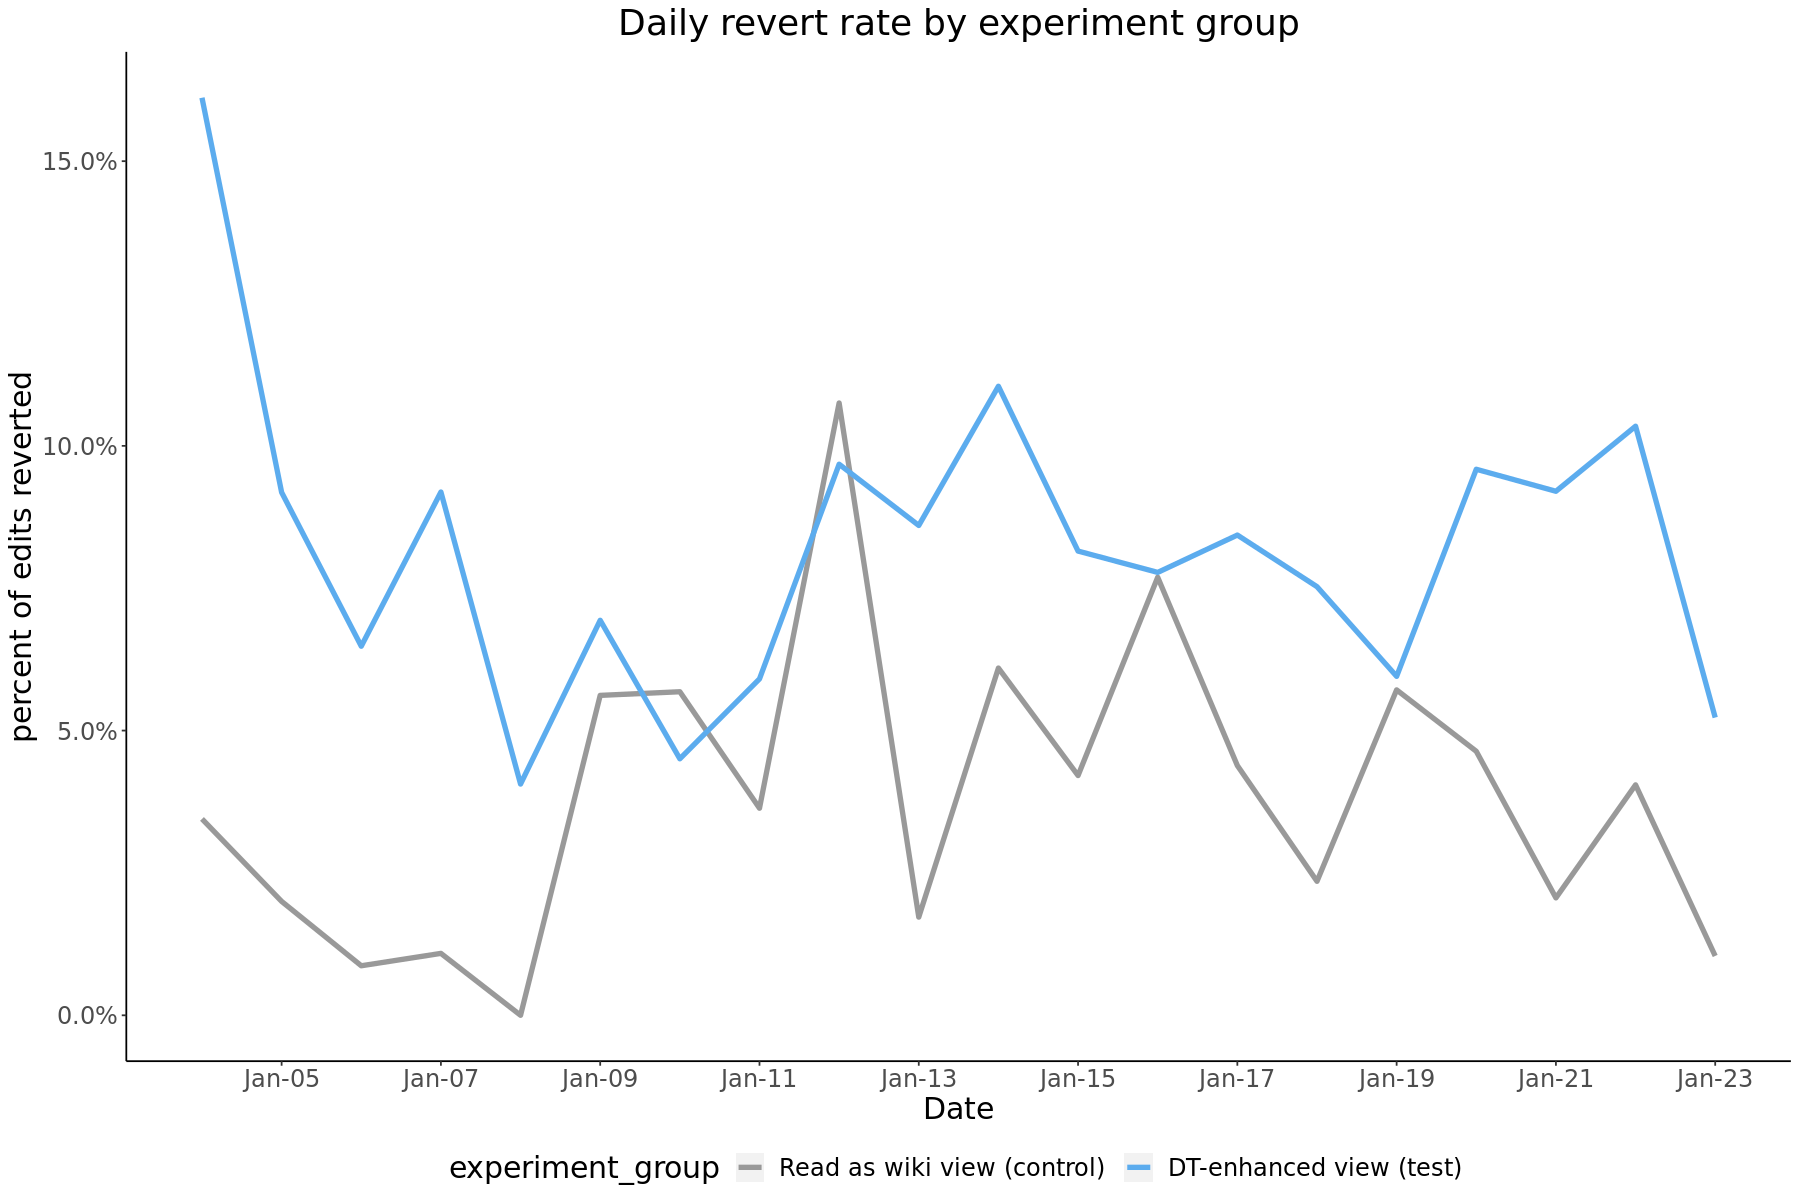

In [610]:
p <- edit_reverts_daily  %>%
    ggplot(aes(x= date, y = pct_reverted , color = experiment_group)) +    
    geom_line(size =1.5) +
    scale_y_continuous(labels = scales::percent) +
    scale_x_date("Date", date_breaks = "2 days", date_labels = "%b-%d") +
    scale_color_manual(values= c("#999999", "steelblue2")) +
  labs(title = "Daily revert rate by experiment group",
      y = "percent of edits reverted",
      x= "Date") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 


ggsave("Figures/edit_reverts_daily.png", p, width = 16, height = 8, units = "in", dpi = 300) 

p


The difference in revert rates between the two groups decreased from a high of 13 percentage point at the start of the AB test to 4.2 percentage points on the last day.

## By Workflow

In [609]:
# edit revert rate
edit_reverts_byworkflow <- edit_attempts_mobile %>%
    filter(is_anon == 'False',
          edit_success == 1) %>% # only published edits
    group_by(experiment_group, workflow) %>%
    summarise(n_saves = n_distinct(edit_attempt_id),
             n_reverts = n_distinct(edit_attempt_id[edit_reverted ==1 ]),
             pct_reverted = round(n_reverts/n_saves,2))


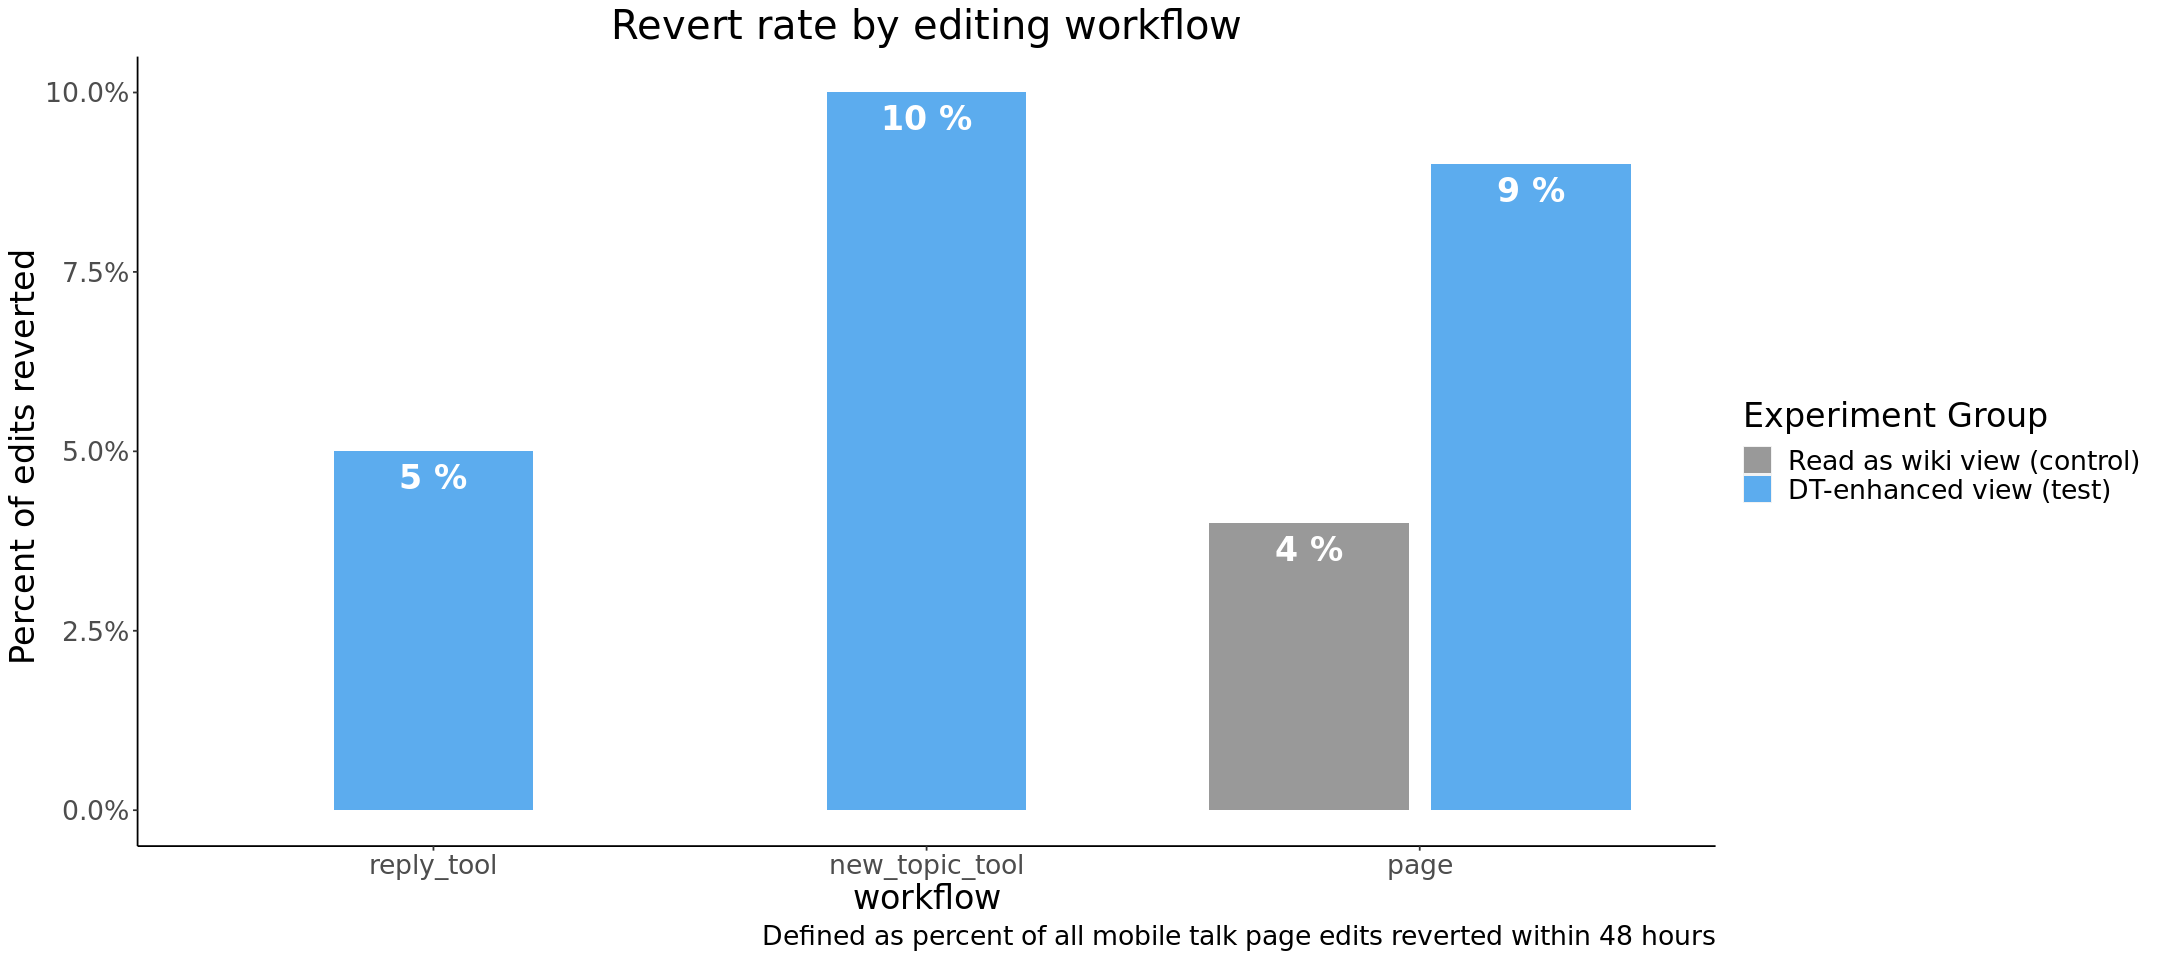

In [520]:
options(repr.plot.width = 18, repr.plot.height = 8)
p <- edit_reverts_byworkflow %>%
    ggplot(aes(x= workflow, y = pct_reverted, fill = experiment_group)) +
    geom_col(position = position_dodge2(preserve = "single")) +
    geom_text(aes(label = paste(pct_reverted * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
    #facet_wrap(~ experiment_group) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of edits reverted ",
          title = "Revert rate by editing workflow",
         caption = "Defined as percent of all mobile talk page edits reverted within 48 hours")  +
    scale_fill_manual(values= c( "#999999", "steelblue2"), name = "Experiment Group" ) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=20),
        legend.position="right",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_reverts_byworkflow.png", p, width = 16, height = 8, units = "in", dpi = 300)

The revert rate is higher across all three workflow groups in the DT-enhanced view, especially for the New Topic Tool. The reply tool revert rate is only 1 percentage point higher than revert rates found with the control group.

## By Editor Experience

In [515]:
# edit revert rate by anon
edit_reverts_byexp <- edit_attempts_mobile %>%
      filter(is_anon == 'False',
          edit_success == 1) %>% # only published edits
    group_by(editor_experience, experiment_group) %>%
    summarise(n_saves = n_distinct(edit_attempt_id),
             n_reverts = n_distinct(edit_attempt_id[edit_reverted ==1 ]),
               pct_reverted = round(n_reverts/n_saves, 2))
              

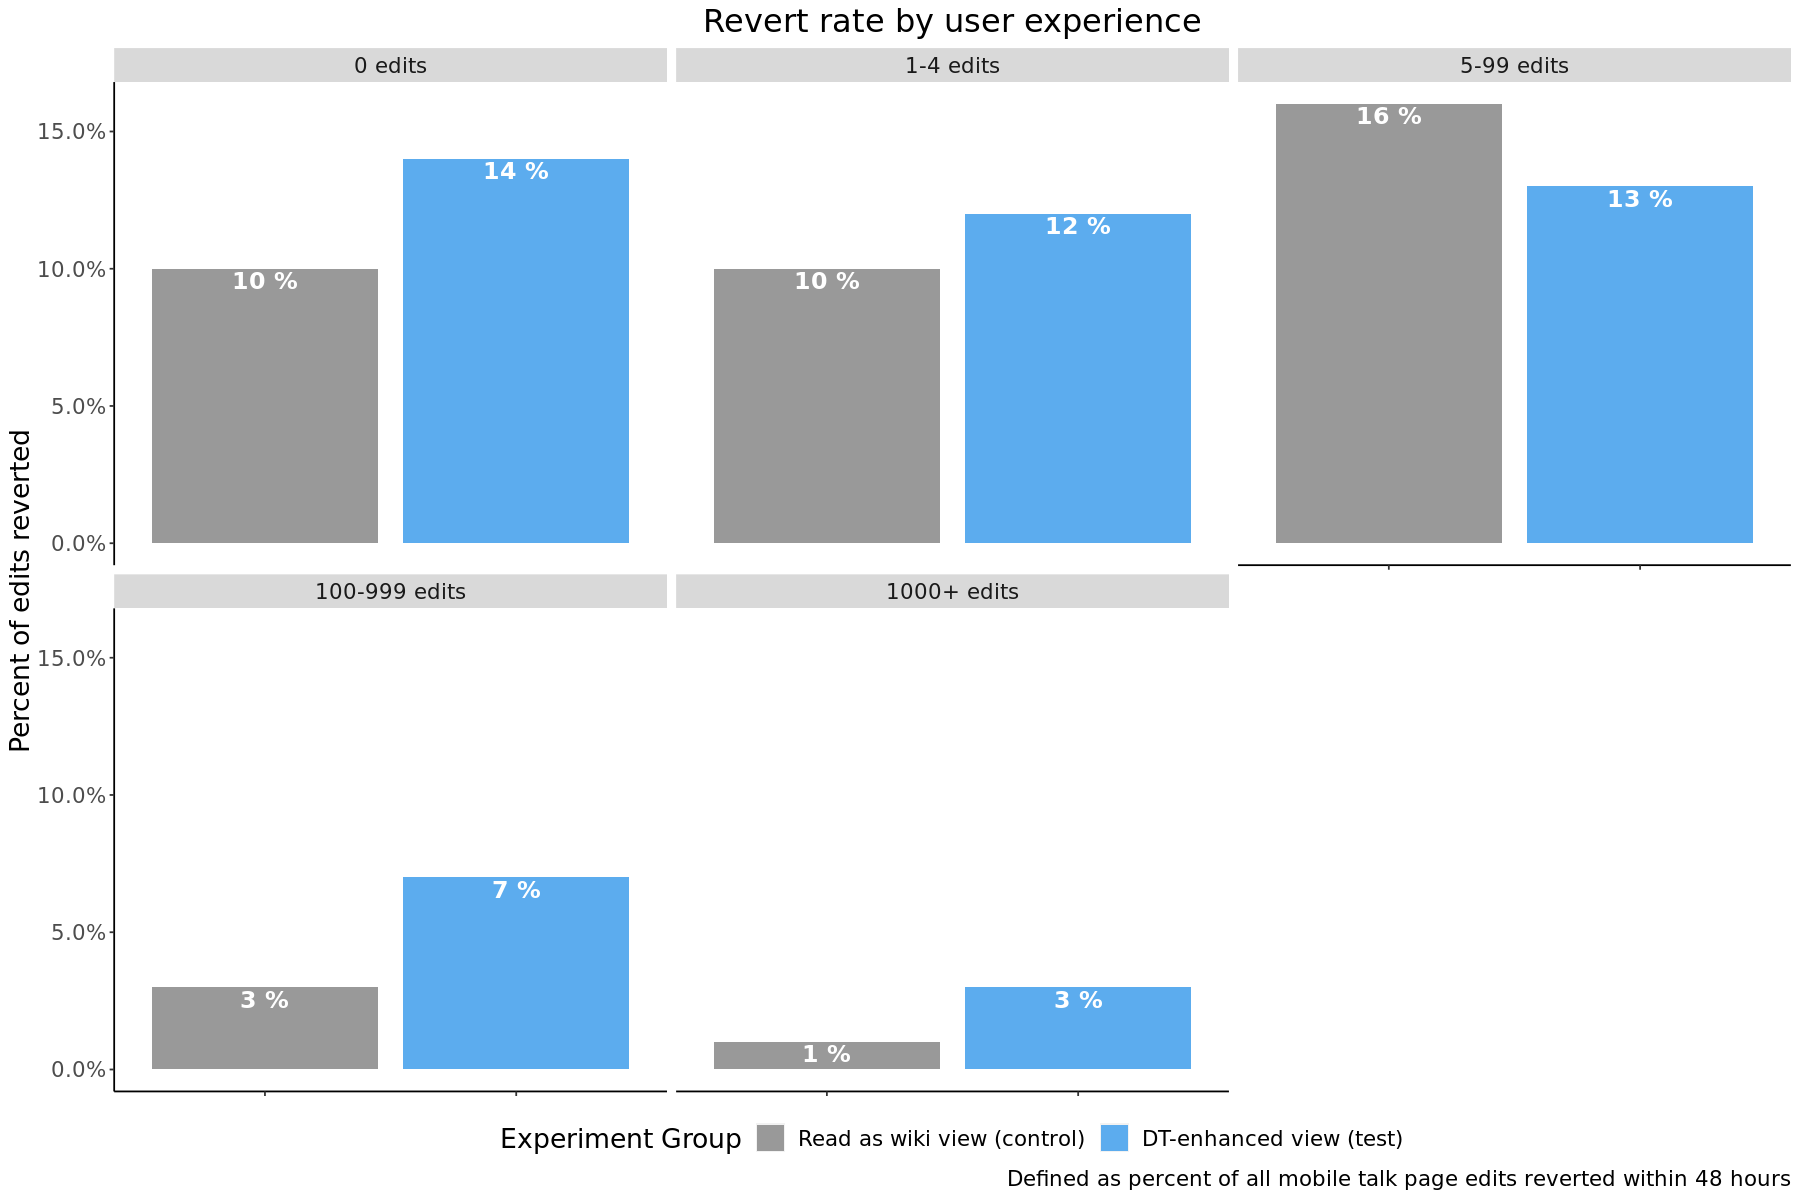

In [516]:
# Plot revert rates for each exp group 


p <- edit_reverts_byexp %>%
    ggplot(aes(x= experiment_group, y = pct_reverted, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(pct_reverted * 100, "%"), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ editor_experience) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of edits reverted ",
          title = "Revert rate by user experience",
         caption = "Defined as percent of all mobile talk page edits reverted within 48 hours")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_reverts_byexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

Users that saw the DT-enhanced view of mobile talk pages had a slightly higher revert rate across all experience groups except users that made between 5-99 edits. None of these increase were above 10 percentage points. 

## By Wikipedia

In [501]:
# edit reverts by wiki
edit_reverts_bywiki<- edit_attempts_mobile %>%
     filter(is_anon == 'False',
          edit_success == 1) %>% # only published edits
    group_by(wiki, experiment_group) %>%
    summarise(n_saves = n_distinct(edit_attempt_id),
             n_reverts = n_distinct(edit_attempt_id[edit_reverted ==1 ]),
               pct_reverted = round(n_reverts/n_saves, 2), .groups = 'drop') 


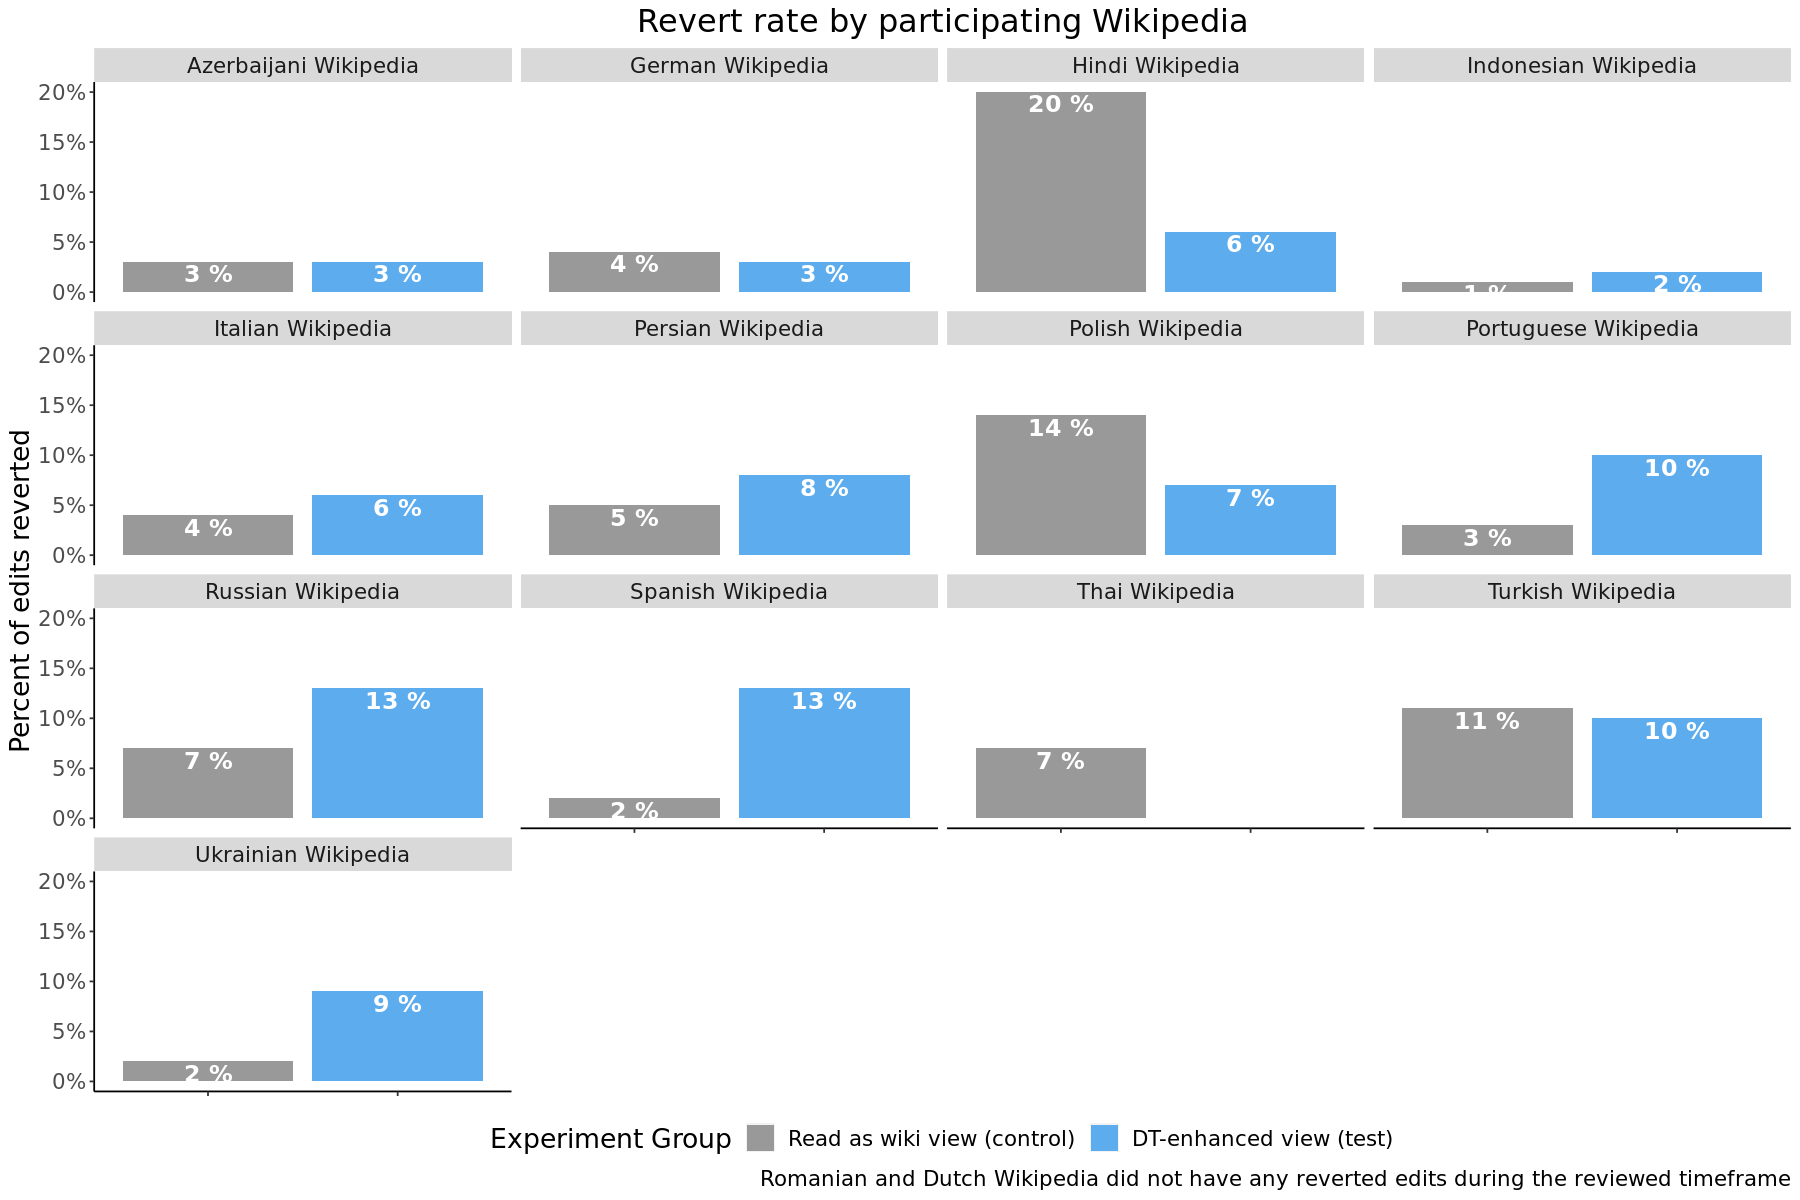

In [511]:
# Plot revert rates for each wiki  


p <- edit_reverts_bywiki %>%
    filter(!(wiki %in% c('Romanian Wikipedia', 'Dutch Wikipedia'))) %>% # remove wikis where no reverts logged
    ggplot(aes(x= experiment_group, y = pct_reverted, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(pct_reverted * 100,"%"), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent_format(accuracy=1)) +
    labs (y = "Percent of edits reverted ",
          title = "Revert rate by participating Wikipedia",
         caption = "Romanian and Dutch Wikipedia did not have any reverted edits during the reviewed timeframe")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_reverts_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

Users that saw the DT-enhanced view had a higher revert rate on all wikis except for Hindi Wikipedia.  
Note that there is a high level of uncertainty around many of these per Wikipedia revert rate values due to the smaller number of published edits and reverts recorded on a per Wikipedia basis, especially for smaller sized Wikipedias. 

# Edit completion rate

We compared the completion rate of edits on mobile talk pages on the DT-enhanced view by the test group to either exisiting Mobile FrontEnd and Read as Wiki views available to the control group.

Note: For the purpose of comparing the edit completion rates between the DT-ehanced view and the existing MobileFrontend commenting experience, we considered the denominator in the edit completion rate to be the firstChange event within the Reply Tool/EditAttemptStep schema. See decision documented in [T302108#7959121](https://phabricator.wikimedia.org/T302108#7959121)


## DT-Enhanced (test) vs Read as Wiki View (control) Completion Rate Comparison

For this comparison, we defined completion rate as the proportion of mobile talk page edit attempts (action = 'init') that are published (action = 'SaveSuccess').

### Overall

In [640]:
# edit completion rate
edit_completes_overall <- edit_attempts_mobile %>%
    filter(is_anon == 'False') %>%
    group_by(experiment_group) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_attempt_id[edit_success ==1 ]),
             pct_completed = paste0(round(n_published/n_attempts * 100, 2), "%"))
              
edit_completes_overall

experiment_group            n_attempts n_published pct_completed
1 Read as wiki view (control) 9060       2301        25.4%        
2 DT-enhanced view (test)     9012       3701        41.07%

 There was a 61% increase in edit completion rate by users that saw the DT-enhanced view compared to the existing read as wiki view.

In [512]:
edit_completes_daily <- edit_attempts_mobile %>%
    filter(is_anon == 'False') %>%
    group_by(date, experiment_group) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_attempt_id[edit_success ==1]),
             pct_completed = n_published/n_attempts)

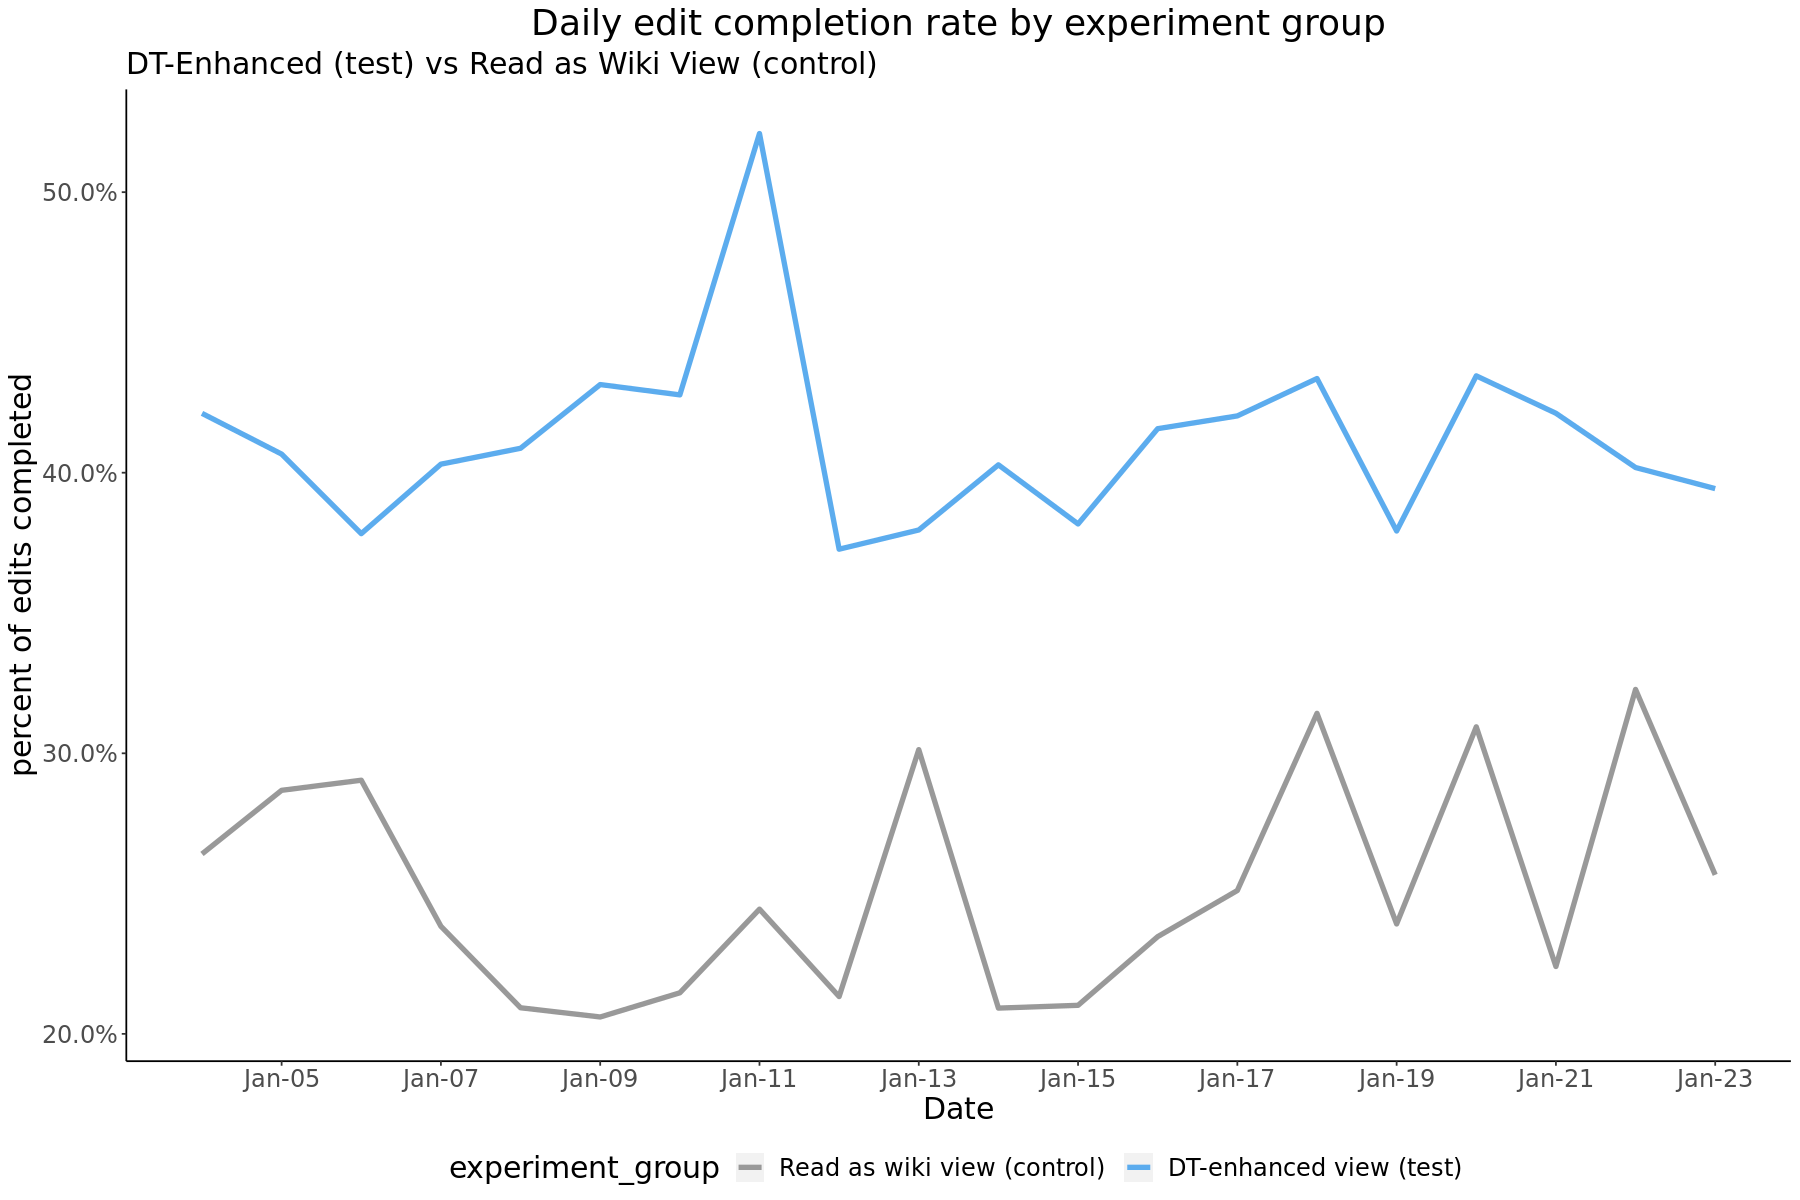

In [624]:
p <- edit_completes_daily  %>%
    ggplot(aes(x= date, y = pct_completed , color = experiment_group)) +    
    geom_line(size =1.5) +
    scale_y_continuous(labels = scales::percent) +
    scale_x_date("Date", date_breaks = "2 days", date_labels = "%b-%d") +
    scale_color_manual(values= c("#999999", "steelblue2")) +
  labs(title = "Daily edit completion rate by experiment group",
       subtitle = "DT-Enhanced (test) vs Read as Wiki View (control)",
      y = "percent of edits completed",
      x= "Date") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 


ggsave("Figures/edit_completes_daily.png", p, width = 16, height = 8, units = "in", dpi = 300) 

p

This observed increase in edit completion rate was sustained for the duration of the AB test.

### By Edit Workflow

In [522]:
# edit completion rate
edit_completes_byintegration <- edit_attempts_mobile %>%
    filter(is_anon == 'False') %>%
    group_by(experiment_group, workflow) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_attempt_id[edit_success ==1 ]),
             pct_completed = round(n_published/n_attempts, 2))
              

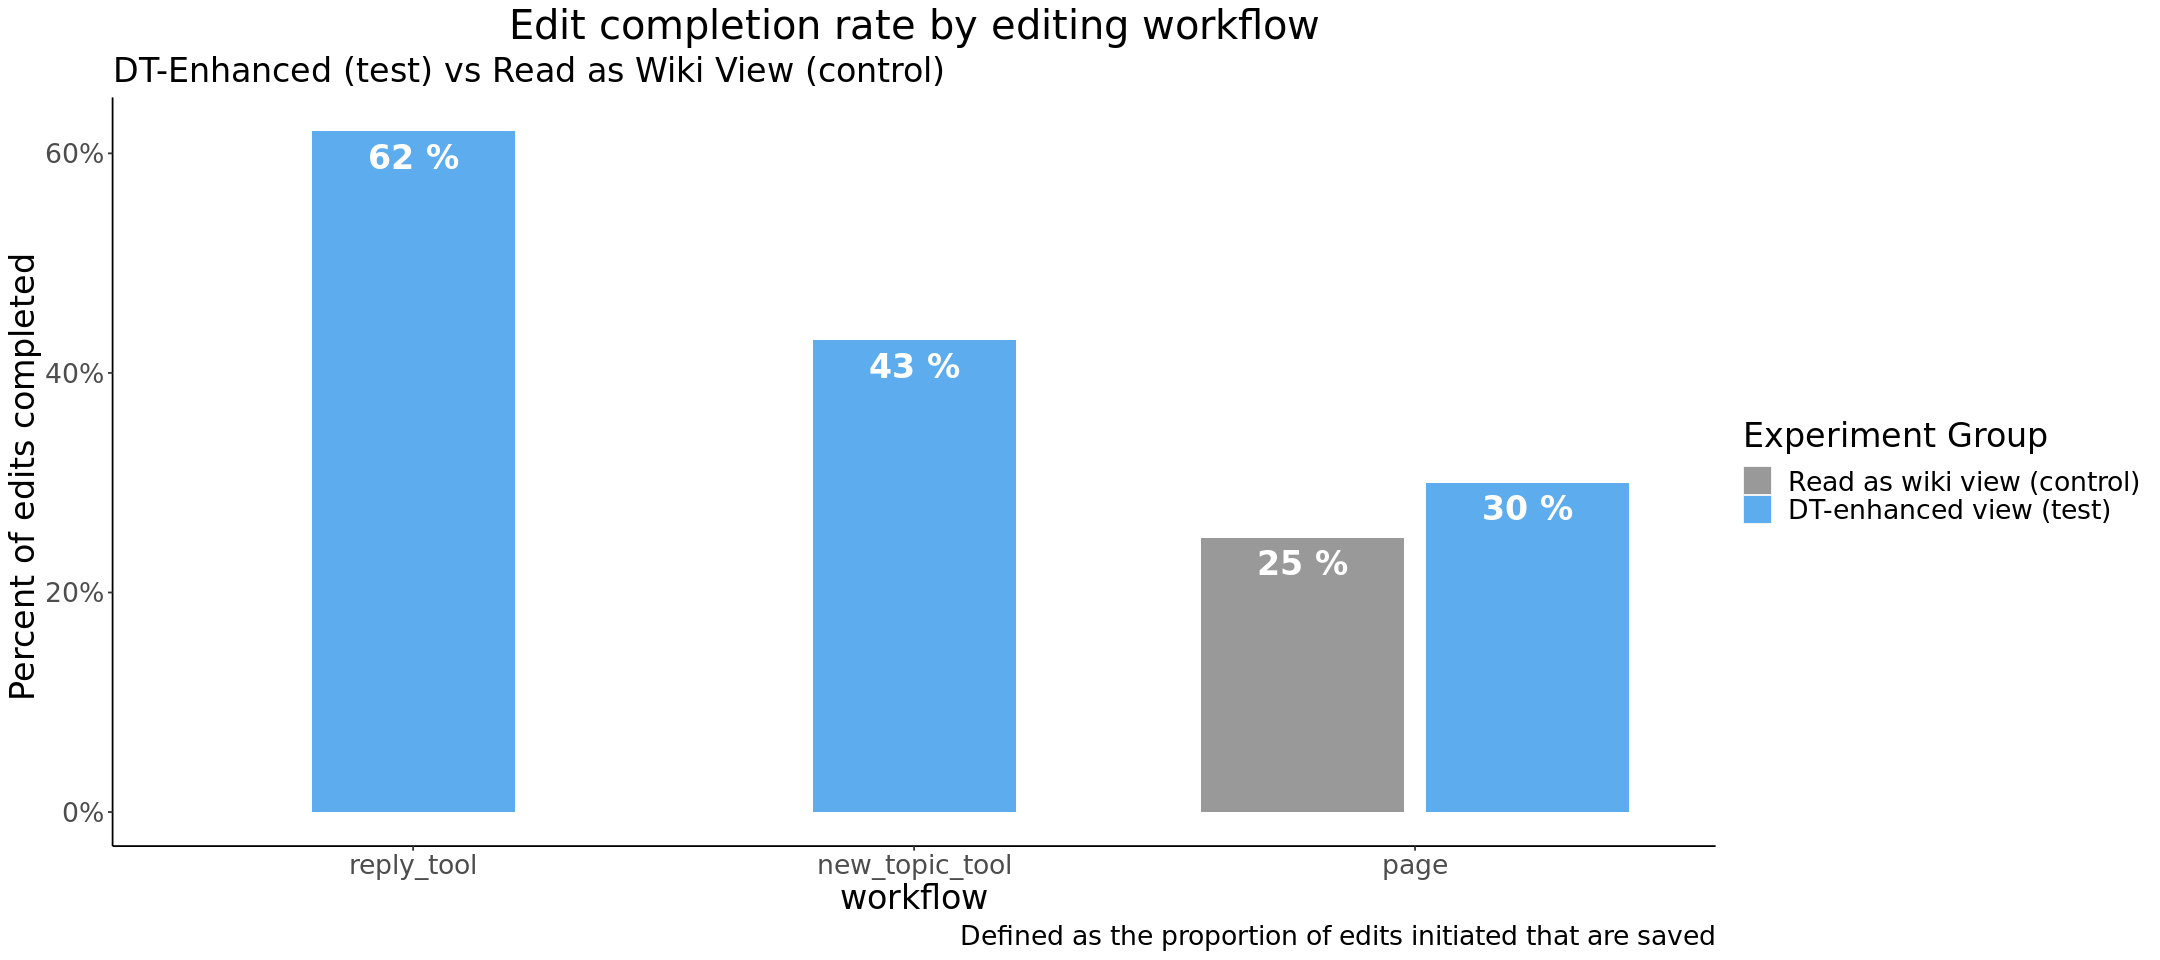

In [641]:
options(repr.plot.width = 18, repr.plot.height = 8)
p <- edit_completes_byintegration %>%
    ggplot(aes(x= workflow, y = pct_completed, fill = experiment_group)) +
    geom_col(position = position_dodge2(preserve = "single")) +
    geom_text(aes(label = paste(pct_completed * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
    #facet_wrap(~ experiment_group) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of edits completed ",
          title = "Edit completion rate by editing workflow",
          subtitle = "DT-Enhanced (test) vs Read as Wiki View (control)",
         caption = "Defined as the proportion of edits initiated that are saved")  +
    scale_fill_manual(values= c( "#999999", "steelblue2"), name = "Experiment Group" ) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=20),
        legend.position="right",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_completes_byintegration.png", p, width = 16, height = 8, units = "in", dpi = 300)

Edit completion rate for all three editing workflows on the DT-enhanced view had a higher edit completion rate than edits made by users shown the Read as wiki view. There was a 2x increase in the edit completion rate with the reply tool compared to edits on the Read as Wiki view. 

### By Editor Experience

In [626]:
# edit completion rate
edit_completes_byexp <- edit_attempts_mobile %>%
    group_by(editor_experience, experiment_group) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_attempt_id[edit_success ==1 ]),
             pct_completed = round(n_published/n_attempts, 2))
              

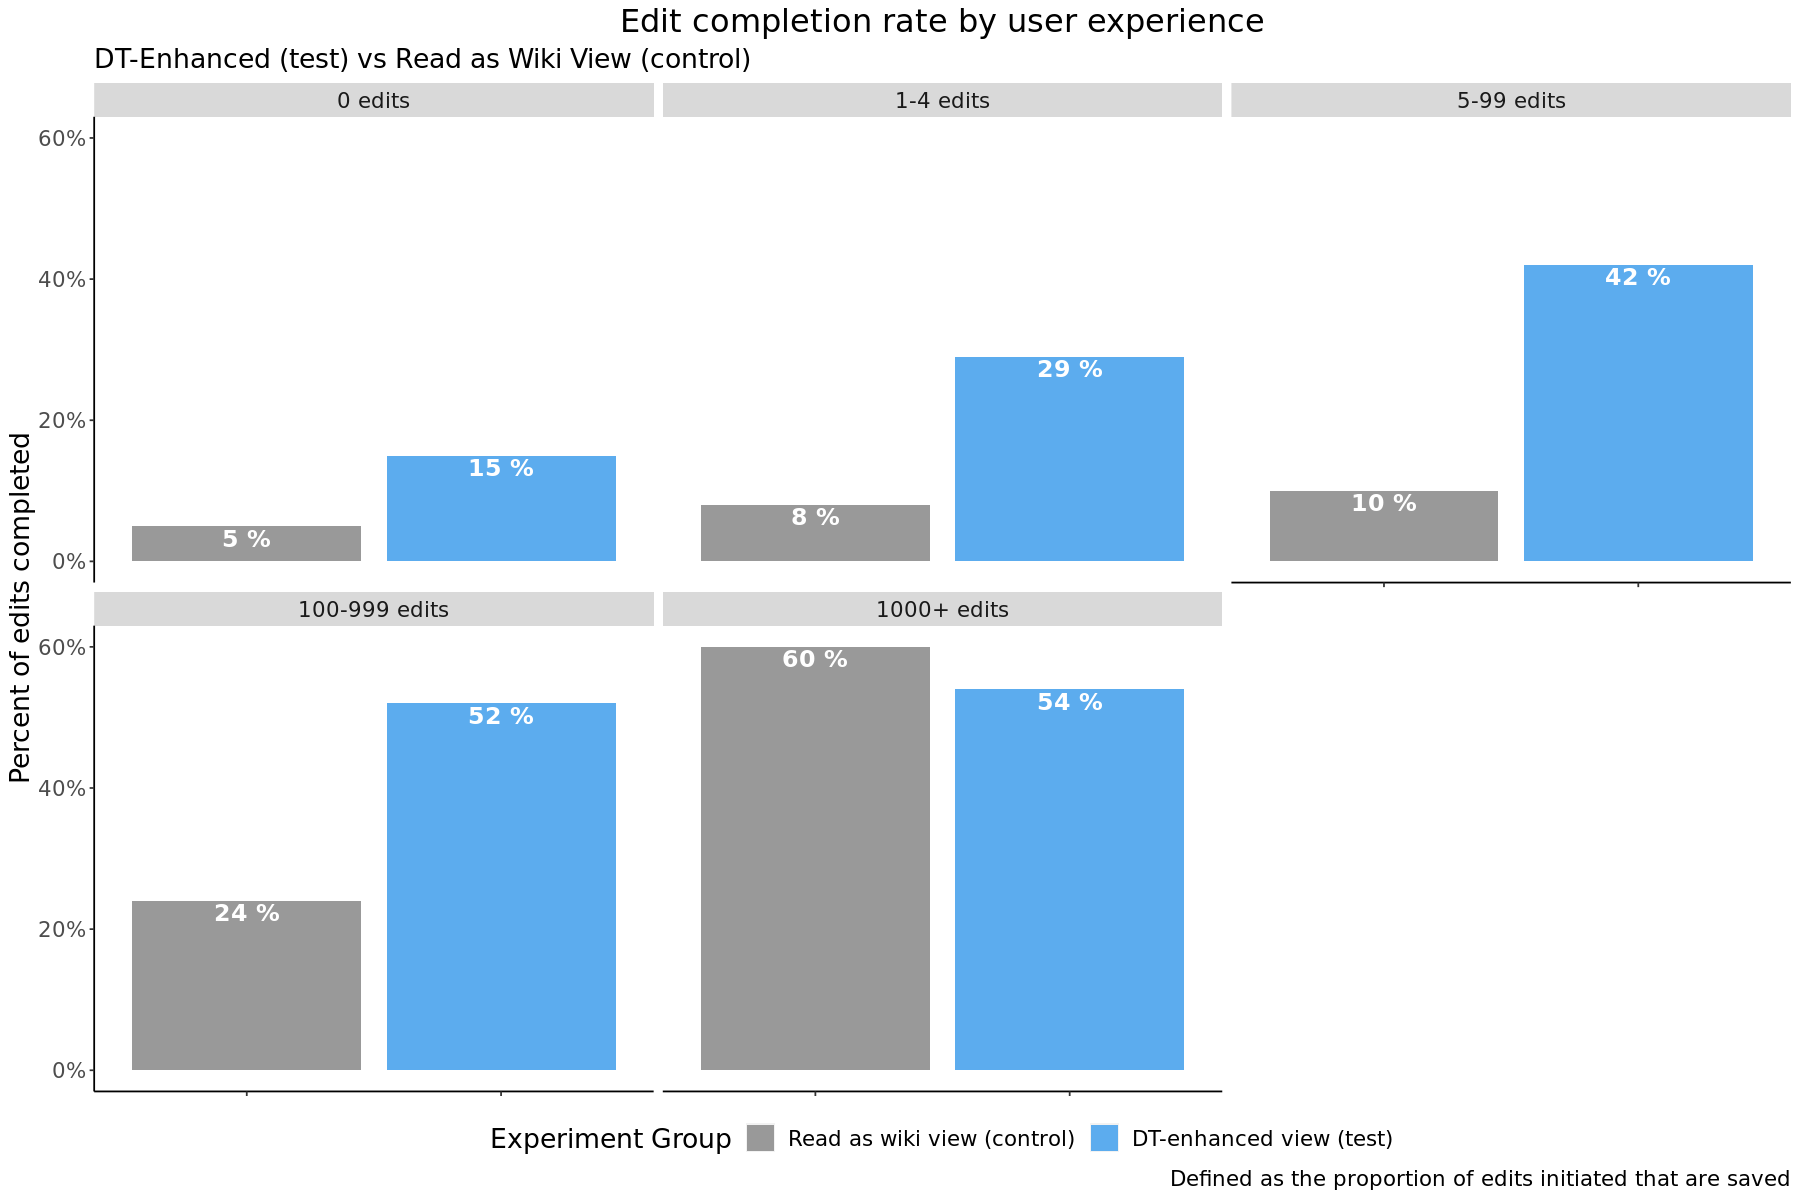

In [627]:
# Plot edit completion rate for each wiki 
options(repr.plot.width = 15, repr.plot.height = 10)

p <- edit_completes_byexp %>%
    ggplot(aes(x= experiment_group, y = pct_completed, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(pct_completed * 100, "%"), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ editor_experience) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of edits completed ",
          title = "Edit completion rate by user experience",
          subtitle = "DT-Enhanced (test) vs Read as Wiki View (control)",
         caption = "Defined as the proportion of edits initiated that are saved")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_completes_byexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

Edit completion rate increased across all experience levels except for the senior editors with over 1000+ edits, where a slight decrease in edit completion rate was observed. This is similar to trends identified for discussion tools used on desktop talk pages.

### By Participating Wikipedia

In [628]:
# edit completion rate by wiki
edit_completes_bywiki <- edit_attempts_mobile %>%
    filter(is_anon == 'False') %>%
    group_by(wiki, experiment_group) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_attempt_id[edit_success ==1 ]),
             pct_completed = round(n_published/n_attempts, 2))

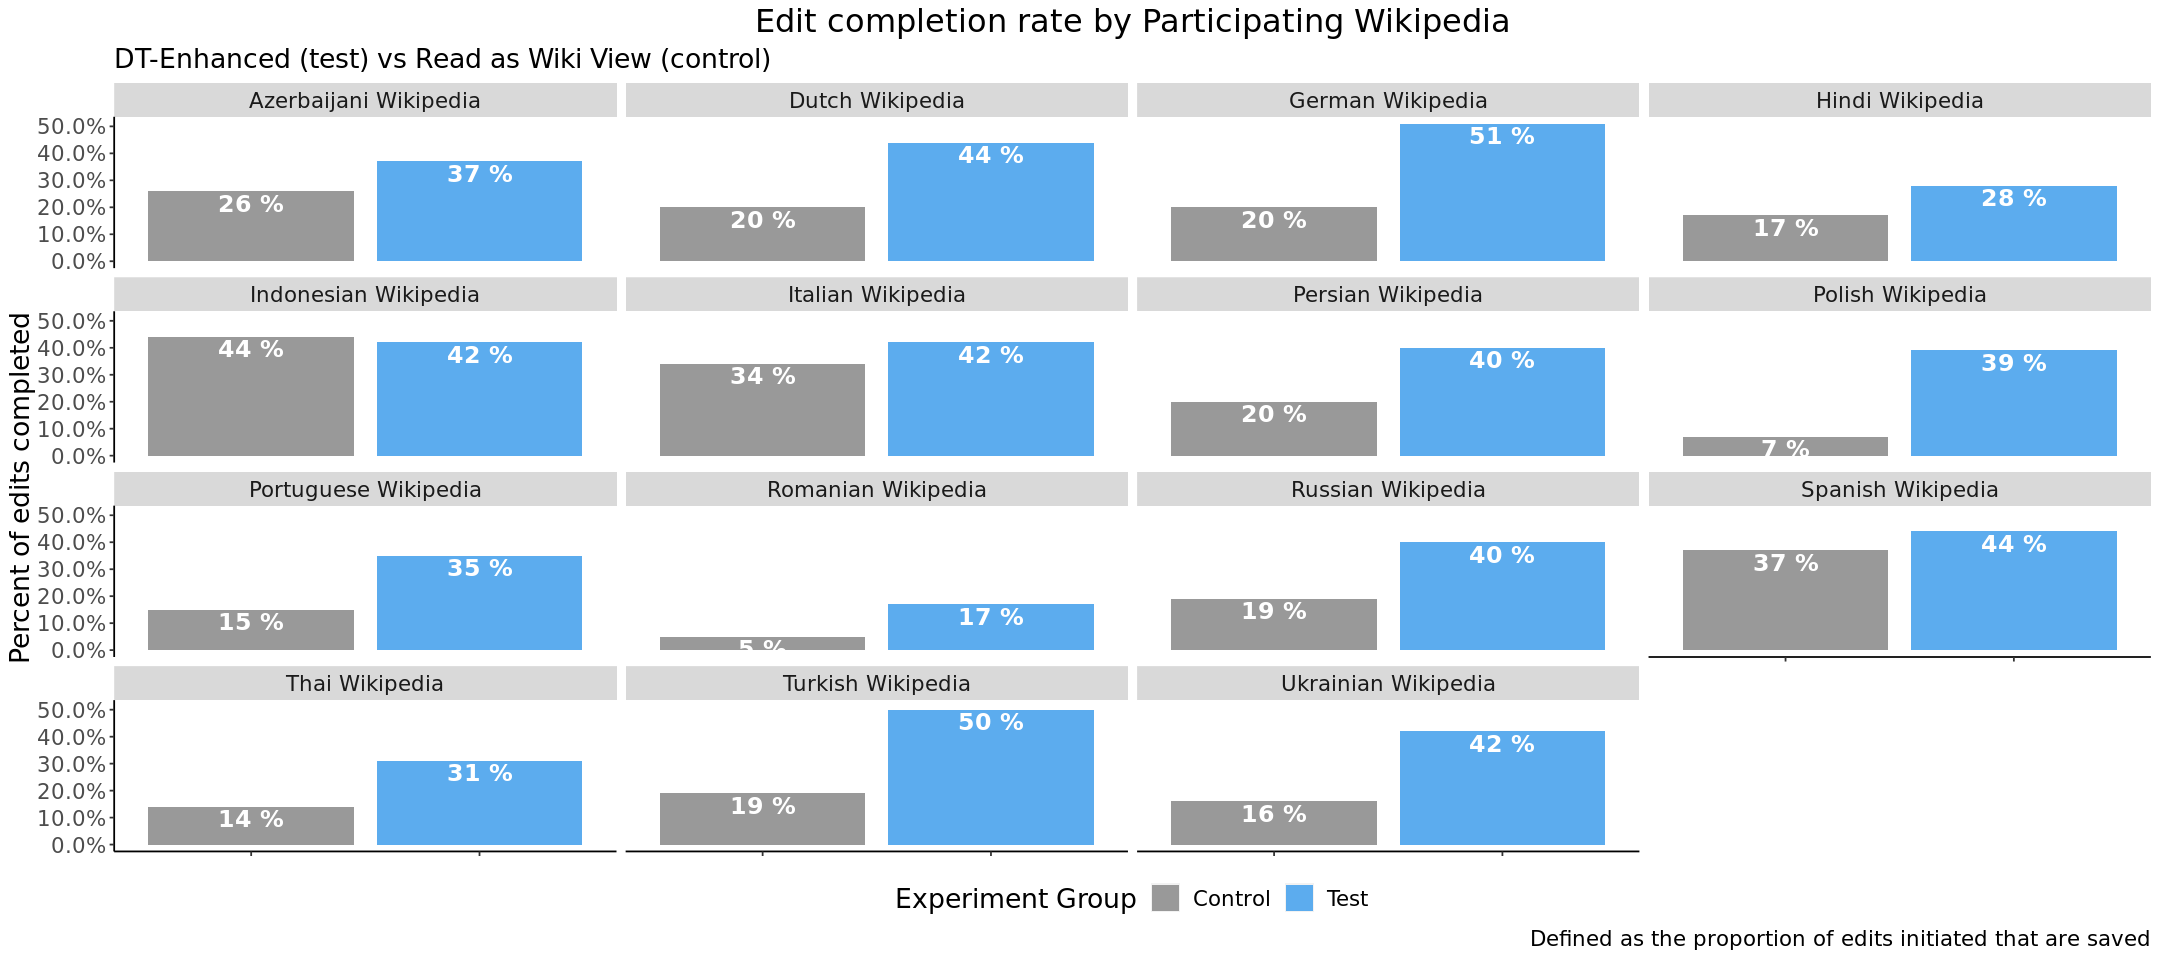

In [642]:
# Plot edit completion rates for each wiki  


p <- edit_completes_bywiki %>%
    ggplot(aes(x= experiment_group, y = pct_completed, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(pct_completed * 100, "%"), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of edits completed ",
          title = "Edit completion rate by Participating Wikipedia",
          subtitle = "DT-Enhanced (test) vs Read as Wiki View (control)",
         caption = "Defined as the proportion of edits initiated that are saved")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group", labels = c("Control", "Test"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_completes_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

We observed increased in edit completion rate on each participating Wikipedia with the exception of Indonesian Wikipedia.

## DT-Enhanced (test) vs MobileFrontEnd overlay (control) Completion Rate Comparison

This comparison was done separately to the Read as Wiki comparison as the MobileFrontEnd events are recorded slightly differently in `MobileWebUIActionsTracking` and the commenting workflow requires a different set of steps by the user. Specifically, 

* Completion rate here is defined as the proportion of unique browser sessions that publish at least one new topic or 1 reply. This is because the MobileWebUIActionTracking schema does not track unique users and does not have an editing session id. 
* For the purpose of comparing the edit completion rates between the Reply Tool and the existing MobileFrontend commenting experience, we will consider the denominator in the edit completion rate to be the firstChange event within the Reply Tool/EditAttemptStep schema.  See details in [T302108](https://phabricator.wikimedia.org/T302108).
* We specifically reviewed replying and new topic workflows on the MobileFrontEnd overlay to the reply tool and new topic tool workflows on the DT-enhanced version.


In [560]:
# reformat read as wiki dataset to be comparable to mobile

edit_attempts_mobile_for_overlay_compare <-  edit_attempts_mobile %>%
    filter(workflow != 'page') %>%  #only look at replies and new topics in test group  
    group_by(date, wiki, session, is_anon, workflow, editor_experience) %>%
    summarise(init_clicks = sum(edit_change),  #look at first change edits as denominator
              save_clicks = sum(edit_success),
             edit_success = as.integer(if_else(save_clicks > 0, 1, 0))) %>%
    mutate(view = 'DT-Enhanced view (test)')  %>% # add column to specify view mode
    ungroup()

In [592]:
# combine tables

edit_attempts_mobilefrontend_compare <- rbind(edit_attempts_mobile_for_overlay_compare, edit_attempts_mobilefrontend)

# add row to only count replies that reach first change as attempted for reply workflow comparison
edit_attempts_mobilefrontend_compare <- edit_attempts_mobilefrontend_compare %>%
 mutate(attempted = if_else(workflow %in% c('reply_tool', 'reply') & init_clicks == 0, 0, 1))

#set factor levels
edit_attempts_mobilefrontend_compare$view <-
  factor(
    edit_attempts_mobilefrontend_compare$view,
    levels = c("MobileFrontend overlay (control)", "DT-Enhanced view (test)")
  )

edit_attempts_mobilefrontend_compare$workflow <-
  factor(
    edit_attempts_mobilefrontend_compare$workflow,
    levels = c("replying workflow", "reply_tool", "new topic workflow", "new_topic_tool")
  )


### Overall

In [630]:
# edit completion rate
edit_completes_overlay_compare_overall <- edit_attempts_mobilefrontend_compare  %>%
    filter(is_anon == 'False') %>%
    group_by(view) %>%
    summarise(n_attempts = n_distinct(session[attempted ==1]), 
             n_published = n_distinct(session[edit_success ==1 ]),
             pct_completed = paste0(round(n_published/n_attempts * 100, 2), "%"))
              
edit_completes_overlay_compare_overall

view                             n_attempts n_published pct_completed
1 MobileFrontend overlay (control) 1121        436        38.89%       
2 DT-Enhanced view (test)          2984       1815        60.82%

Edit completion rate by users shown the DT-enhanced view increased by 56% (22 percentage points) across all participating wikipedias. This is similar to the increase in completion rate for the DT-enhanced view compared to the Read as Wiki view (61%).

In [594]:
edit_completes_daily_overlay <- edit_attempts_mobilefrontend_compare  %>%
    filter(is_anon == 'False') %>%
    group_by(date, view) %>%
    summarise(n_attempts = n_distinct(session[attempted ==1]), 
             n_published = n_distinct(session[edit_success ==1 ]),
             pct_completed = round(n_published/n_attempts, 2))

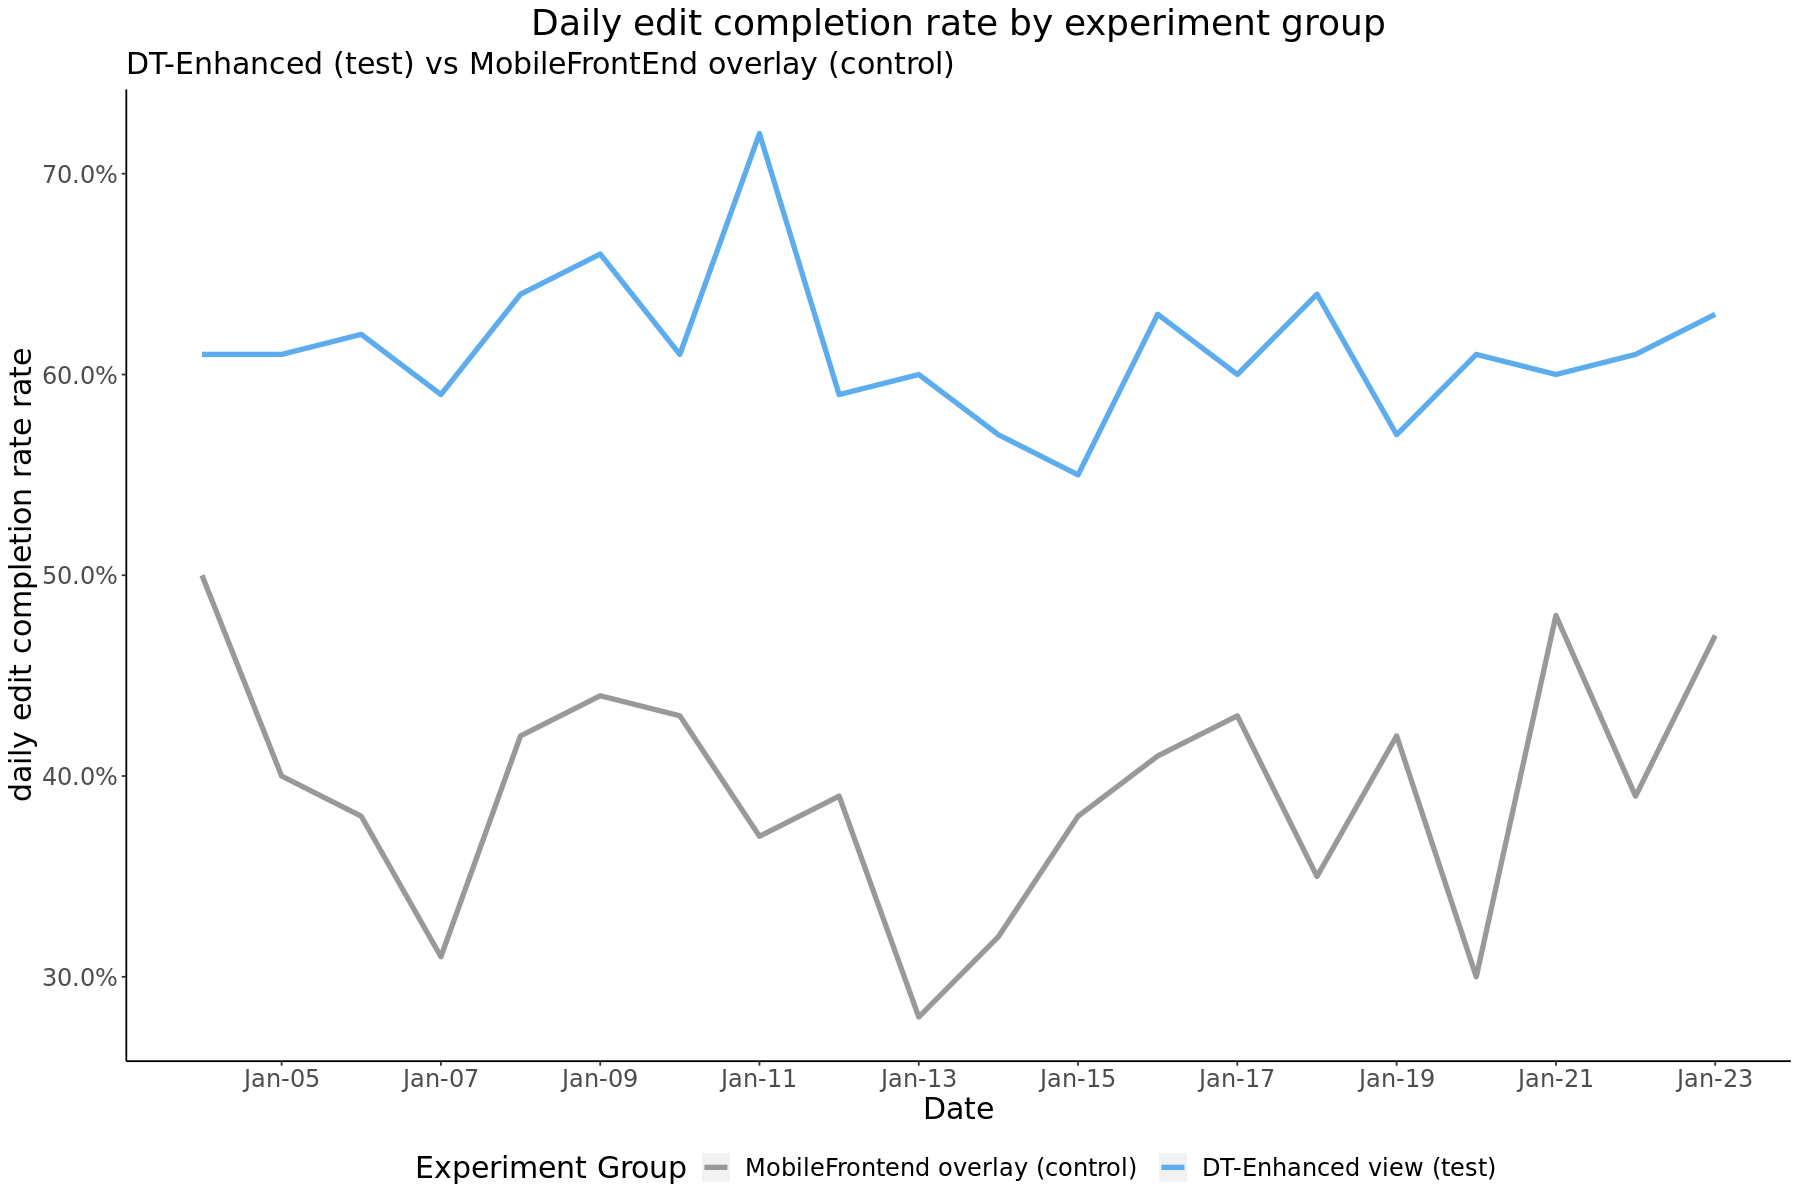

In [631]:
options(repr.plot.width = 15, repr.plot.height = 10)

p <- edit_completes_daily_overlay  %>%
    ggplot(aes(x= date, y = pct_completed , color = view)) +    
    geom_line(size =1.5) +
    scale_y_continuous(labels = scales::percent) +
    scale_x_date("Date", date_breaks = "2 days", date_labels = "%b-%d") +
    scale_color_manual(values= c("#999999","steelblue2"),name = "Experiment Group") +
  labs(title = "Daily edit completion rate by experiment group",
       subtitle = "DT-Enhanced (test) vs MobileFrontEnd overlay (control)",
      y = "daily edit completion rate rate",
      x= "Date") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 


ggsave("Figures/edit_completes_daily_overlay.png", p, width = 16, height = 8, units = "in", dpi = 300) 

p

There has been a sustained increase in edit completion rate for users show the DT-enhanced view compared to mobile talk page edits using the replying and new topic workflows.

### By Workflow

In [597]:
# edit completion rate
edit_completes_overlay_compare_byworkflow <- edit_attempts_mobilefrontend_compare  %>%
    filter(is_anon == 'False') %>%
    group_by(view, workflow) %>%
    summarise(n_attempts = n_distinct(session[attempted ==1]),
             n_published = n_distinct(session[edit_success ==1 ]),
             pct_completed = round(n_published/n_attempts, 2)) 
              

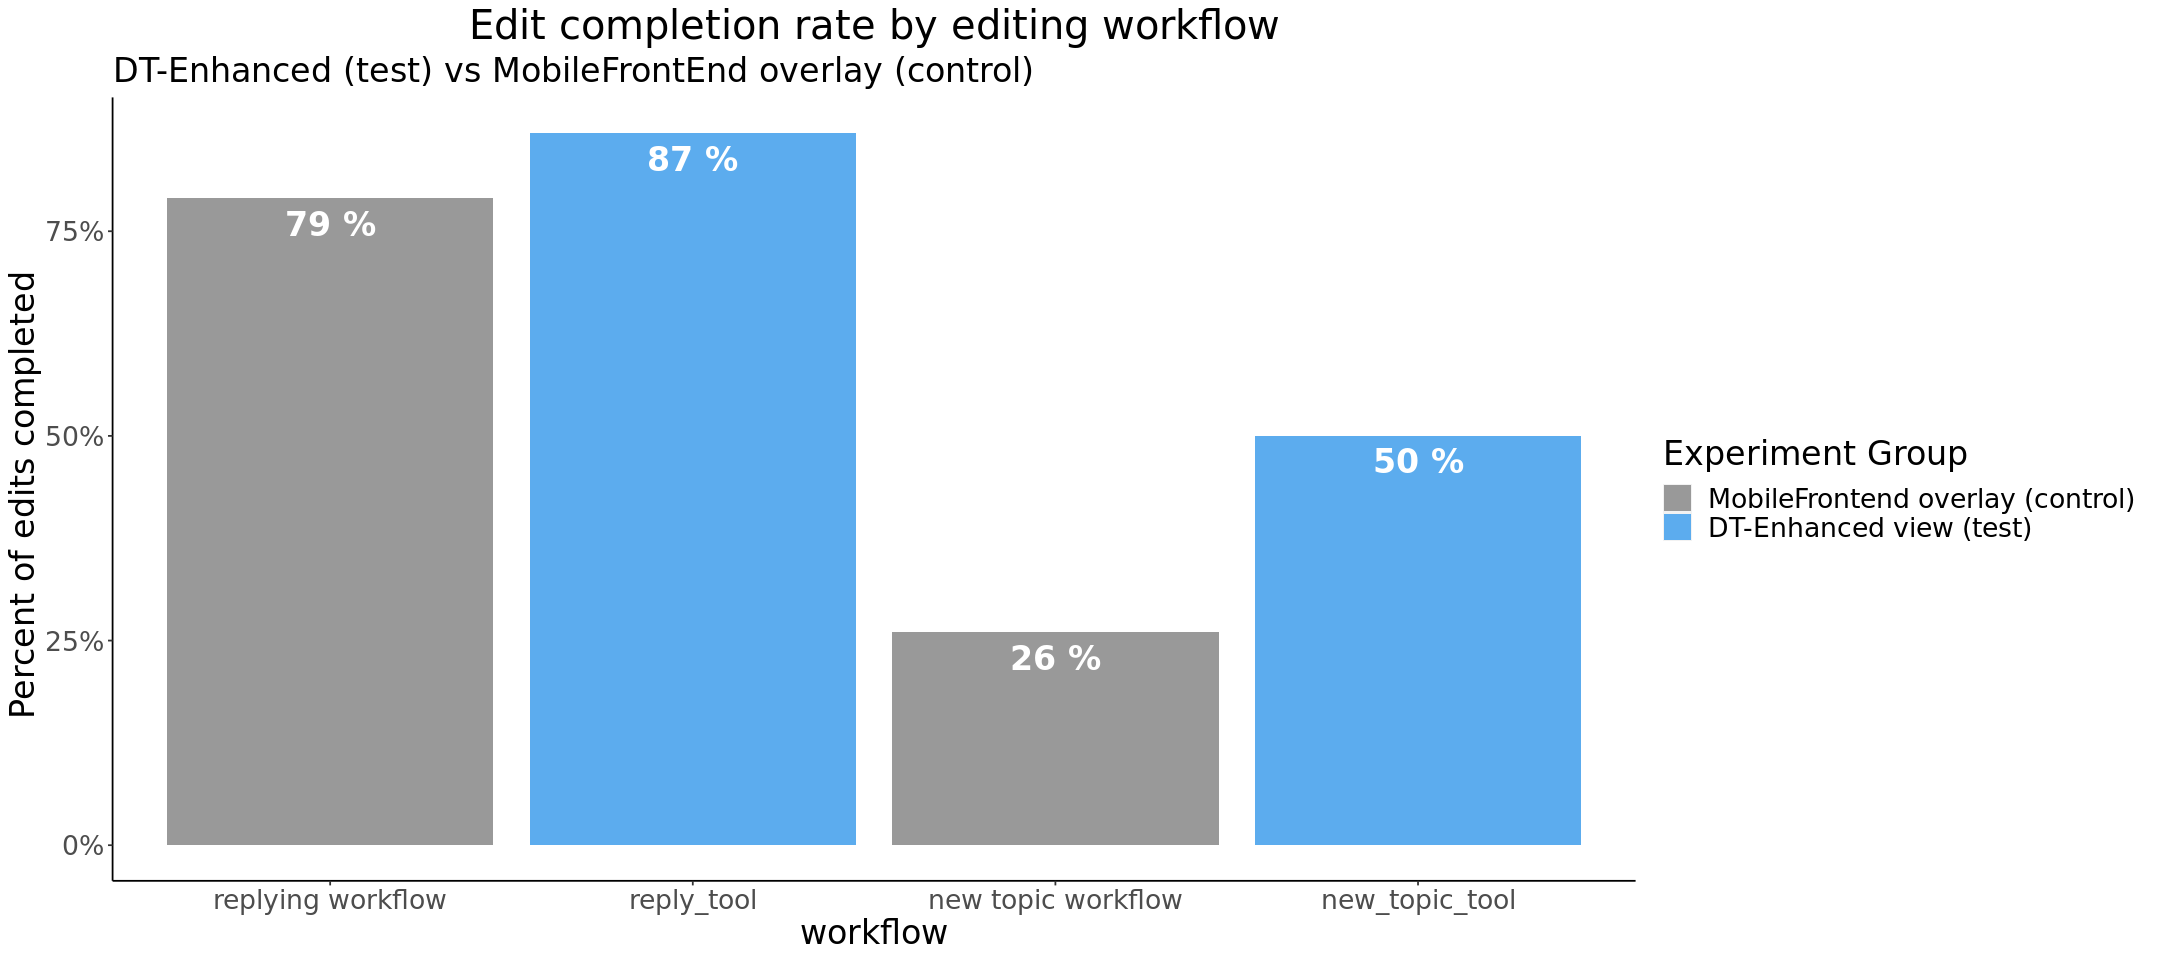

In [643]:
options(repr.plot.width = 18, repr.plot.height = 8)
p <- edit_completes_overlay_compare_byworkflow %>%
    ggplot(aes(x= workflow, y = pct_completed, fill = view)) +
    geom_col(position = position_dodge2(preserve = "single")) +
    geom_text(aes(label = paste(pct_completed * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of edits completed ",
          title = "Edit completion rate by editing workflow",
         subtitle = "DT-Enhanced (test) vs MobileFrontEnd overlay (control)")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group" ) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=20),
        legend.position="right",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_completes_byintegration_overlay.png", p, width = 16, height = 8, units = "in", dpi = 300)

### By Editor Experience

In [599]:
edit_completes_overlay_compare_byexp <- edit_attempts_mobilefrontend_compare  %>%
    filter(is_anon == 'False') %>%
    group_by(editor_experience, view) %>%
    summarise(n_attempts = n_distinct(session[attempted ==1]),
             n_published = n_distinct(session[edit_success ==1 ]),
             pct_completed = round(n_published/n_attempts ,2)) 
              

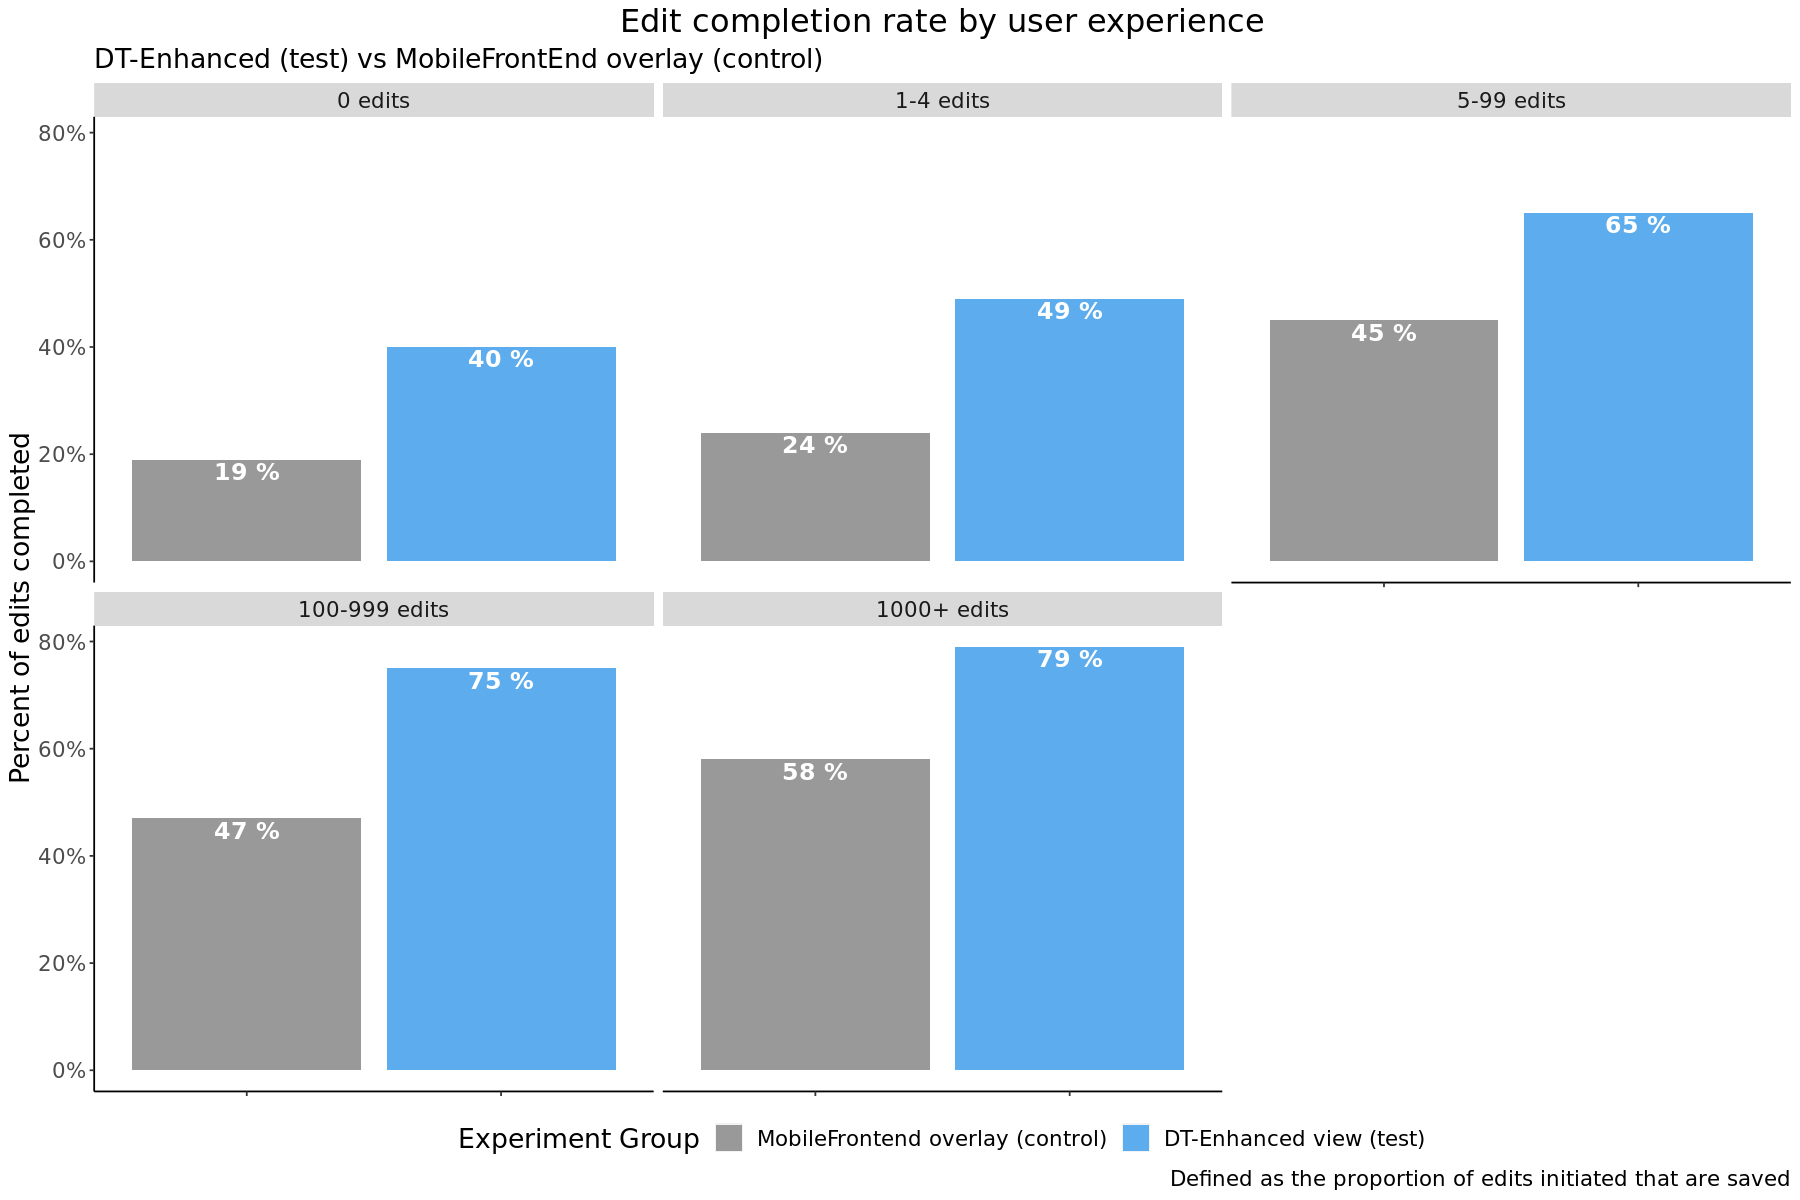

In [633]:
# Plot edit completion rate for each wiki 
options(repr.plot.width = 15, repr.plot.height = 10)

p <- edit_completes_overlay_compare_byexp %>%
    ggplot(aes(x= view, y = pct_completed, fill = view)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(pct_completed * 100, "%"), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ editor_experience) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of edits completed ",
          title = "Edit completion rate by user experience",
          subtitle = "DT-Enhanced (test) vs MobileFrontEnd overlay (control)",
         caption = "Defined as the proportion of edits initiated that are saved")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_completes_byexp_overlay.png", p, width = 16, height = 8, units = "in", dpi = 300)

We observed increases in edit completion rate for users shown the DT-Enhanced view across all editor experience levels.

### By Participating Wikipedia

In [601]:
# edit completion rate
edit_completes_overlay_compare_bywiki <- edit_attempts_mobilefrontend_compare  %>%
    filter(is_anon == 'False') %>%
    group_by(wiki, view) %>%
    summarise(n_attempts = n_distinct(session[attempted ==1]),
             n_published = n_distinct(session[edit_success ==1 ]),
             pct_completed = round(n_published/n_attempts, 2))


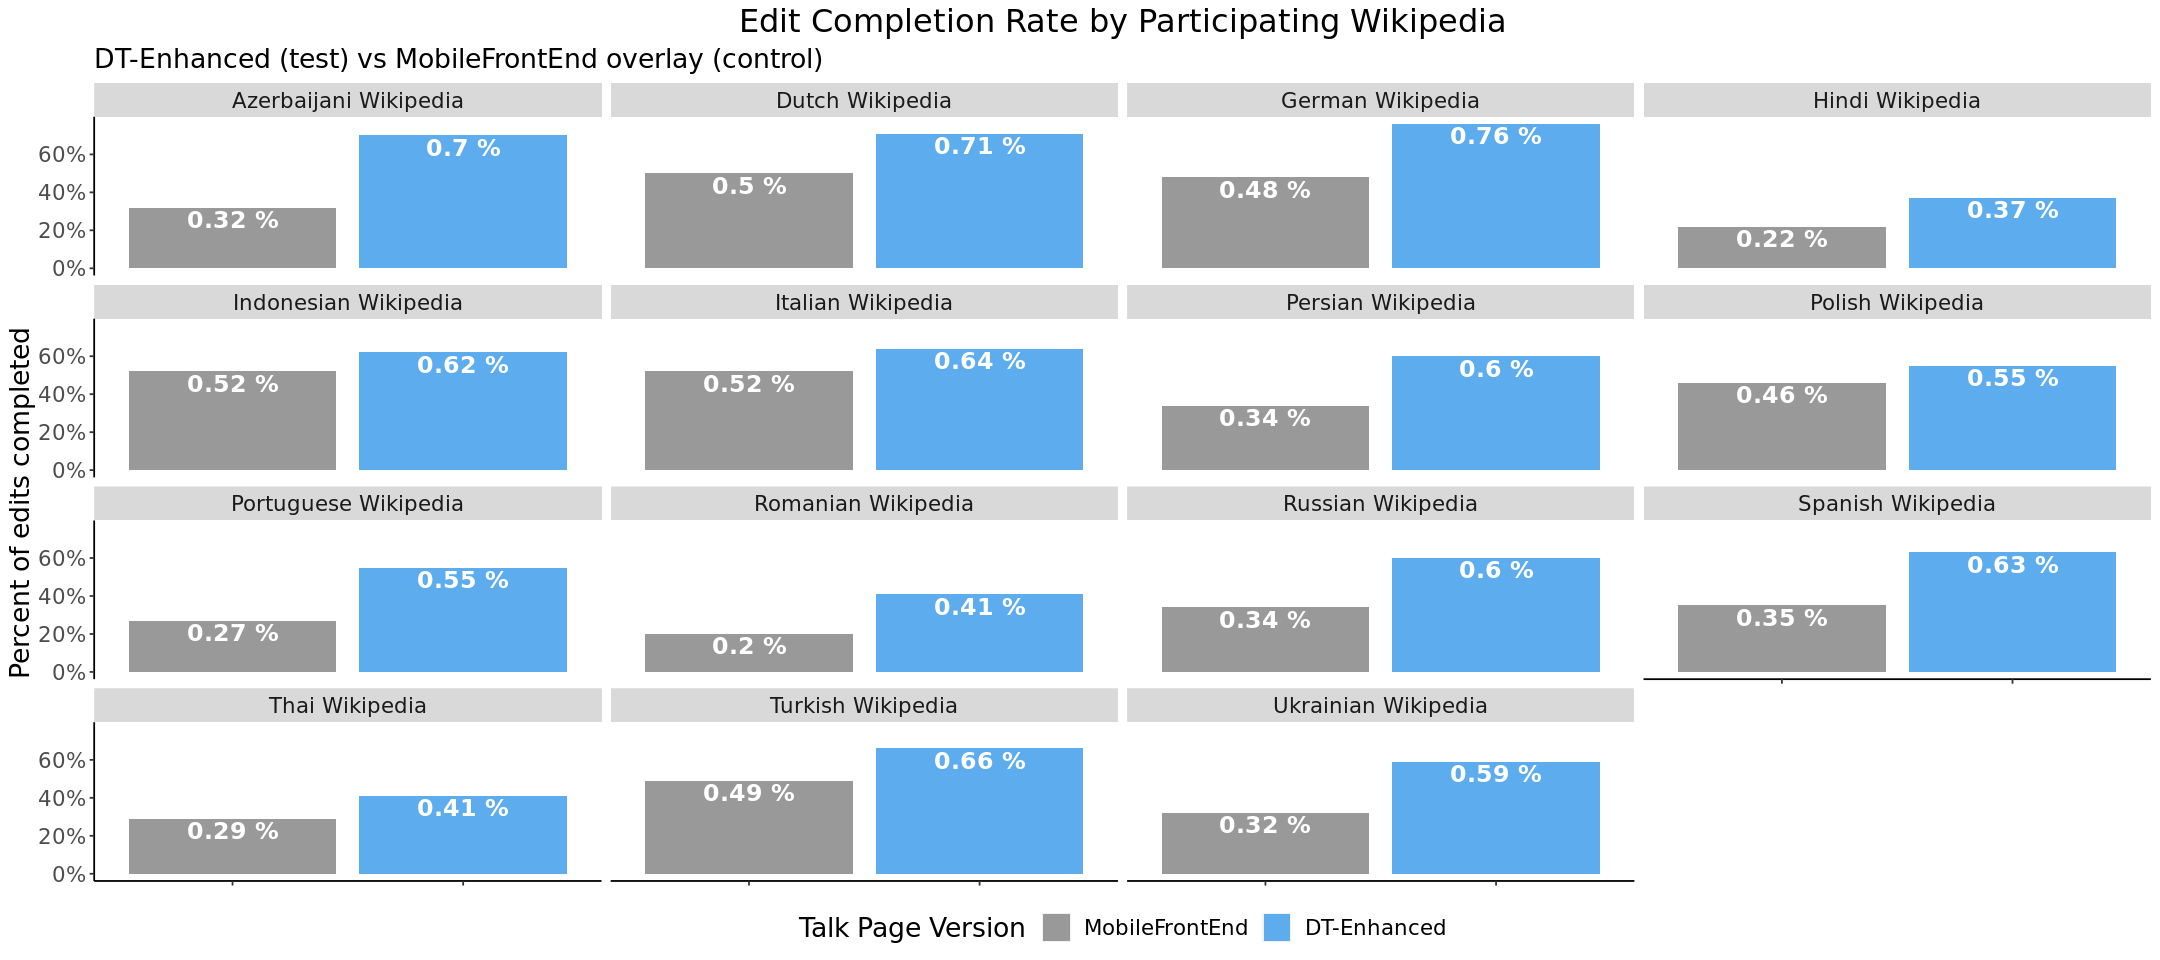

In [644]:
# Plot completion rates for each wiki  


p <- edit_completes_overlay_compare_bywiki  %>%
    ggplot(aes(x= view, y = pct_completed, fill = view)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(pct_completed, "%"), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of edits completed ",
          title = "Edit Completion Rate by Participating Wikipedia",
         subtitle = "DT-Enhanced (test) vs MobileFrontEnd overlay (control)")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Talk Page Version", labels = c("MobileFrontEnd", "DT-Enhanced"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_completes_bywiki_overlay.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [ ]:
Edit completion rate increase were also observed across all participating Wikipedias.

# Proportion of unique editors that sucessfully save at least 1 edit

Unlike the edit completion rate analysis in the prior section, this metric looks at the proportion of unique editors that clicked on an editing affordance on a mobile talk page and saved at least 1 edit.

Note: A comparison for this metric could only be completed for DT Enhanced vs Read as Wiki views because mobilefrontend data did not include a unique user id to determine distinct users.

## Overall

In [5]:
# edit completion rate
user_completes_overall <- edit_attempts_mobile %>%
    filter(is_anon == 'False') %>%
    group_by(experiment_group) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_published = n_distinct(user_id[edit_success == 1]),
             pct_completed = paste0(round(n_users_published/n_users * 100, 2), "%"))
              
user_completes_overall 

experiment_group            n_users n_users_published pct_completed
1 Read as wiki view (control) 3320     512              15.42%       
2 DT-enhanced view (test)     2712    1310              48.3%

## By Workflow

In [6]:
user_completes_byworkflow <- edit_attempts_mobile %>%
    filter(is_anon == 'False') %>%
    group_by(experiment_group, workflow) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_published = n_distinct(user_id[edit_success == 1]),
             pct_completed = round(n_users_published/n_users, 2))
              

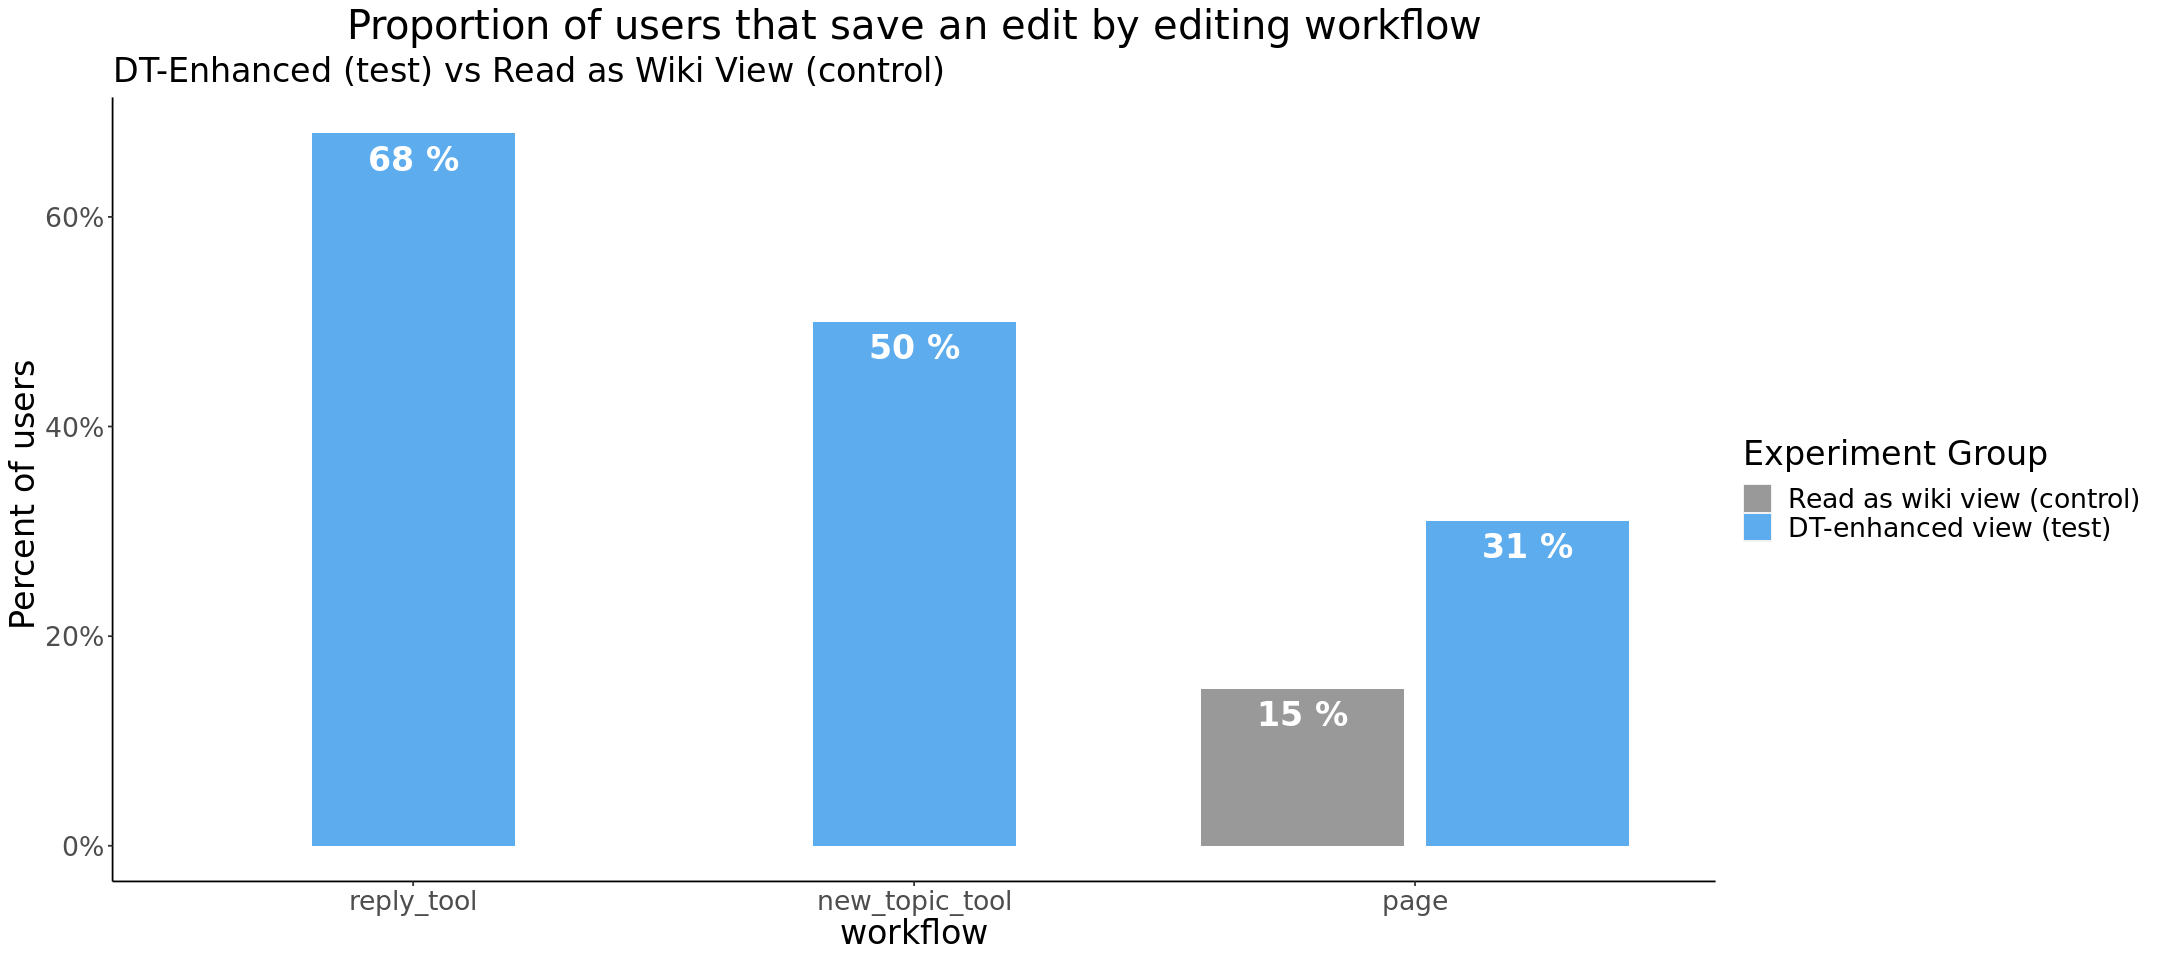

In [7]:
options(repr.plot.width = 18, repr.plot.height = 8)
p <- user_completes_byworkflow %>%
    ggplot(aes(x= workflow, y = pct_completed, fill = experiment_group)) +
    geom_col(position = position_dodge2(preserve = "single")) +
    geom_text(aes(label = paste(pct_completed * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of users ",
          title = "Proportion of users that save an edit by editing workflow",
         subtitle = "DT-Enhanced (test) vs Read as Wiki View (control)")  +
    scale_fill_manual(values= c( "#999999", "steelblue2"), name = "Experiment Group" ) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=20),
        legend.position="right",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/user_completes_byworkflow.png", p, width = 16, height = 8, units = "in", dpi = 300)

## By Editor Experience

In [585]:
# edit completion rate
user_completes_byexp <- edit_attempts_mobile %>%
    group_by(editor_experience, experiment_group) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_published = n_distinct(user_id[edit_success == 1]),
             pct_completed = round(n_users_published/n_users, 2))
              

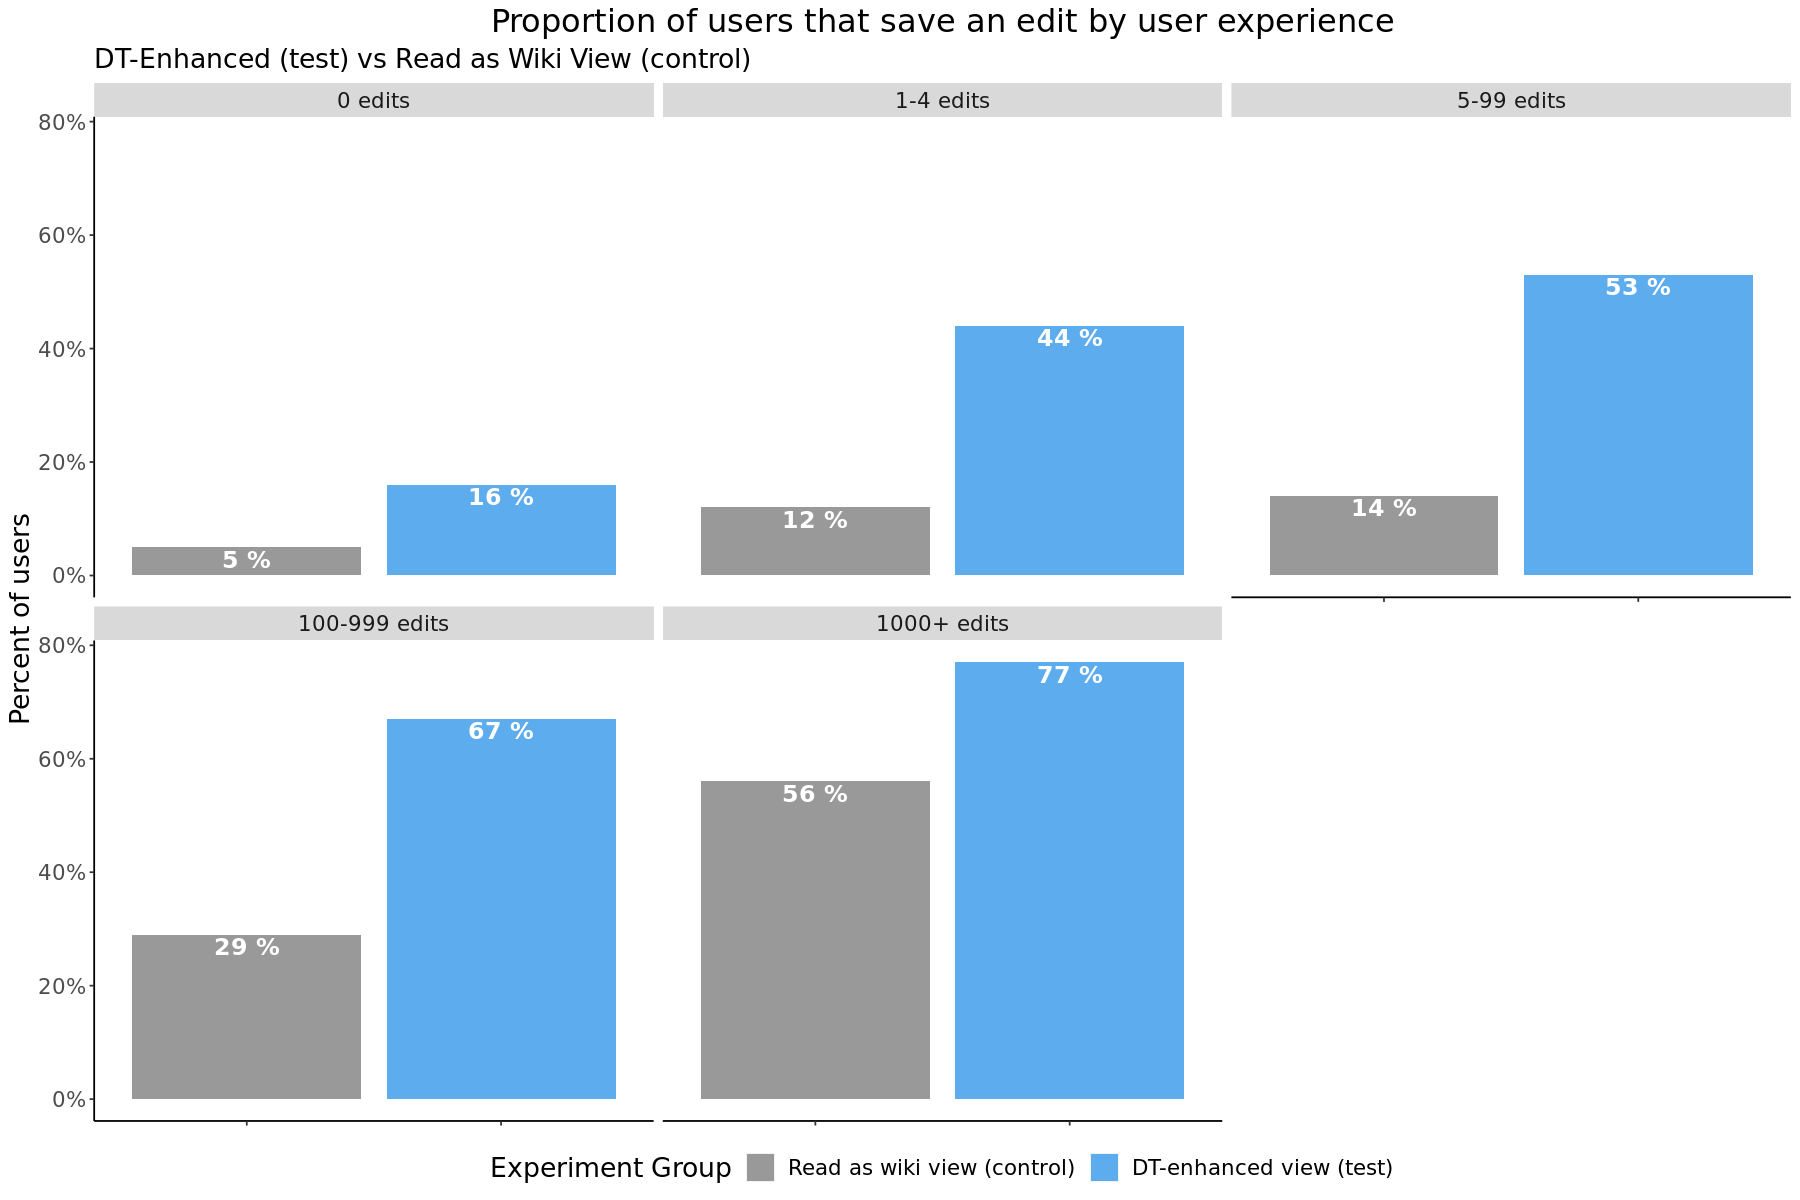

In [638]:
# Plot edit completion rate for each wiki 
options(repr.plot.width = 15, repr.plot.height = 10)

p <- user_completes_byexp %>%
    ggplot(aes(x= experiment_group, y = pct_completed, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(pct_completed * 100, "%"), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ editor_experience) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of users",
          title = "Proportion of users that save an edit by user experience",
         subtitle = "DT-Enhanced (test) vs Read as Wiki View (control)")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/user_completes_byexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

## By Wikipedia

In [410]:
# edit completion rate
user_completes_bywiki <- edit_attempts_mobile %>%
    filter(is_anon == 'False') %>%
    group_by(wiki, experiment_group) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_published = n_distinct(user_id[edit_success == 1]),
             pct_completed = round(n_users_published/n_users, 2))
              

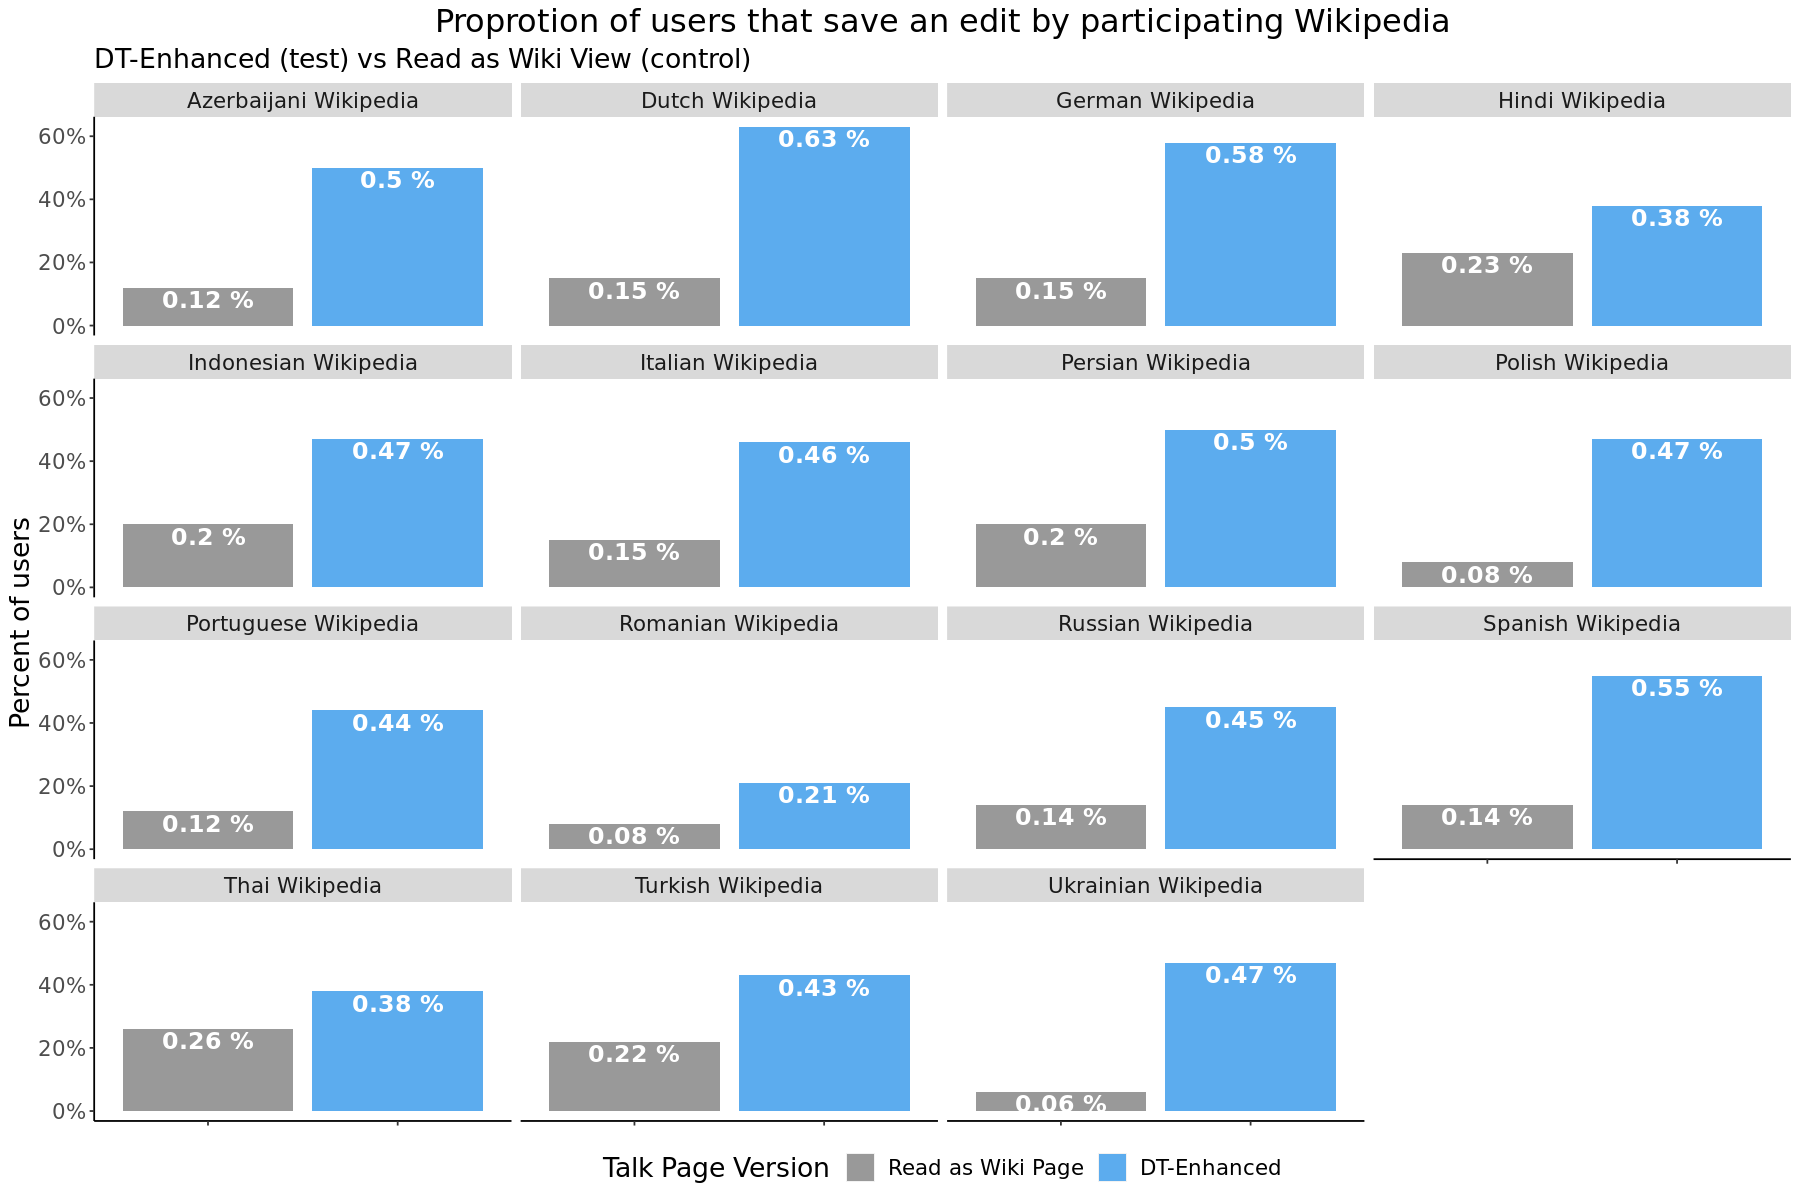

In [639]:
# Plot completion rates for each wiki  


p <- user_completes_bywiki  %>%
    ggplot(aes(x= experiment_group, y = pct_completed, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(pct_completed, "%"), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of users ",
          title = "Proprotion of users that save an edit by participating Wikipedia",
         subtitle = "DT-Enhanced (test) vs Read as Wiki View (control)")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Talk Page Version", labels = c("Read as Wiki Page", "DT-Enhanced"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/user_completes_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

Similar and consistent increases in edit completion rate were observed when we define edit completion rate as the proportion of users that saved at least 1 edit.